# DSI 5 Capstone Project: Amazon Product Recommender System

---

<a id='model-results'></a>
#### Model Results:

| Section | Model | RMSE Score | Recall Score^ | Avg Hit Rate | Model Details
| --- | --- | --- | --- | --- |
| [4.1.1](#4.1.1) | User-User Collaborative Filtering | 1.11062 | 0.02554 | 0.17 ± 0.26 | from scratch |
| [4.1.2](#4.1.2) | User-User Collaborative Filtering | 1.01662 | 0.00851 | 0.18 ± 0.12 | Surprise Library, k=3 |
| [4.1.3](#4.1.3) | User-User Collaborative Filtering Grid Search | 1.01655 | 0.01064 | 0.19 ± 0.13 | Surprise Library, k=7 |
| [4.1.4](#4.1.4) | Item-Item Collaborative Filtering | 1.07621 | 0.00478 | 0.23 ± 0.28 | Surprise Library, k=3 |
| [4.1.5](#4.1.5) | Item-Item Collaborative Filtering Grid Search | 1.07593 | 0.00478 | 0.25 ± 0.28 | Surprise Library, k=7 |
| [4.2.1.1](#4.2.1.1) | Singular Value Decomposition (SVD) | 0.94625 | 0.01436 | 0.20 ± 0.19 | Surprise Library, k=20 |
| [4.2.1.2](#4.2.1.2) | SVD GridSearch | 0.93873 | 0.01064 | 0.16 ± 0.11 | Surprise Library, k=10 |
| [4.2.1.3](#4.2.1.3) | SVD | 0.94057 | 0.01969 | 0.21 ± 0.22 | Surprise Library, k=40 |
| [4.2.2.1](#4.2.2.1) | SVD++ | 0.94458 | 0.00745 | 0.19 ± 0.23 | Surprise Library, k=20 |
| [4.2.2.2](#4.2.2.2) | SVD++ GridSearch| 0.94515 | 0.00957 | 0.21 ± 0.22 | Surprise Library, k=10 |

^Recall Score = 

# 1. Loading in Datasets and Libraries

In [1]:
import gzip

import numpy as np
import scipy.stats as stats
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from surprise import Reader, Dataset, KNNWithMeans, SVD, SVDpp, NMF, evaluate,  accuracy, model_selection

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
from scipy.sparse.linalg import svds

from sklearn.metrics import pairwise_distances, mean_squared_error

In [2]:
# loading in reviews dataset
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./dataset/reviews_Home_and_Kitchen_5.json.gz')

In [1]:
reviews = df.copy()

NameError: name 'df' is not defined

In [4]:
# add product name to reviews dataset
reviews.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"


In [5]:
# loading in metadata 
metadata = pd.read_csv('./dataset/home-kitchen-metadata.csv')
metadata.head(2)

,Unnamed: 0,asin,brand,categories,description,imUrl,price,related,salesRank,title
0,415636,0615391206,Zoku,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",This book will help you master the art of crea...,http://ecx.images-amazon.com/images/I/41EEhiqv...,17.29,"{'also_viewed': ['B003U9ZCRO', 'B003VJWUE6', '...",{'Kitchen & Dining': 3900},Zoku Quick Pops Recipe Book
1,472805,0689027818,NaN,[['Home & Kitchen']],KIDS BOOK ON BUTTERFLIES,http://ecx.images-amazon.com/images/I/51B0H32D...,473.68,"{'also_viewed': ['1581170912', '0399226907']}",{'Home &amp; Kitchen': 1017975},"Good Night, Sweet Butterflies: A Color Dreamland"


In [6]:
product_lookup = {k:v for k,v in zip(metadata['asin'], metadata['title'])}

In [7]:
category_lookup = {k:v for k,v in zip(metadata['title'], metadata['categories'])}

In [8]:
imgurl_lookup = {k:v for k,v in zip(metadata['title'], metadata['imUrl'])}

In [70]:
def categories_to_columns(row, cat_level):
    try:
        return row[cat_level]
    except IndexError:
        return np.nan

In [71]:
categories = metadata.copy()
categories = categories[['asin', 'title', 'categories']]
categories['Category Path'] = categories['categories'].apply(lambda x: [cat.strip() for cat in re.sub('[\[\]\'\"]', '', x).split(',')])

# categories['cat_4'] = categories['Category Path'].apply(lambda x: categories_to_columns(x,4))
for i in range(1, 5):
    categories['cat_'+str(i)] = categories['Category Path'].apply(lambda x: categories_to_columns(x, i-1))

In [72]:
categories.fillna('NA', inplace=True)

In [73]:
categories['broad_cat'] = categories['cat_2']+' > '+categories['cat_3']
categories['narrow_cat'] = categories['cat_2']+' > '+categories['cat_3']+ ' > '+categories['cat_4']

In [74]:
categories.sample(2)

,asin,title,categories,Category Path,cat_1,cat_2,cat_3,cat_4,broad_cat,narrow_cat
2946,B00012F3U4,One 6 diameter Bamboo Skimmer/Strainer,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...","[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,Kitchen & Dining,Kitchen Utensils & Gadgets,Cooking Utensils,Kitchen & Dining > Kitchen Utensils & Gadgets,Kitchen & Dining > Kitchen Utensils & Gadgets ...
774,B000053U7F,Vacu Vin Vacuum Instant Marinater,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...","[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,Kitchen & Dining,Kitchen Utensils & Gadgets,Meat & Poultry Tools,Kitchen & Dining > Kitchen Utensils & Gadgets,Kitchen & Dining > Kitchen Utensils & Gadgets ...


In [75]:
category_lookup_short = {k:v for k,v in zip(categories['title'],categories['narrow_cat'])}
category_lookup_short

{'Zoku Quick Pops Recipe Book': 'Kitchen & Dining > Kitchen Utensils & Gadgets > Specialty Tools & Gadgets',
 'Good Night, Sweet Butterflies: A Color Dreamland': 'NA > NA > NA',
 'Wilton Decorating Cakes Book': 'Kitchen & Dining > Bakeware > Baking & Cookie Sheets',
 'Vandor 52423 Star Wars Large Recycled Shopper Tote, Multicolored': 'Kitchen & Dining > Storage & Organization > Reusable Grocery Bags',
 'Franklin SPELLING CORRECTOR': 'Kitchen & Dining > Kitchen Utensils & Gadgets > Tool & Gadget Sets',
 'Mighty Bright Fold-n-Stow Book Holder': 'Kitchen & Dining > Kitchen Utensils & Gadgets > Kitchen Accessories',
 'Best Choice 2013 Design Fist Cup Brass Knuckle Duster Handle Coffee Milk Ceramic Fist Mug Cup Cool Gift': 'Kitchen & Dining > Dining & Entertaining > Cups',
 'World Pride Mickey Mouse Face Shape Cookie Cutter': 'Kitchen & Dining > Bakeware > Baking Tools & Accessories',
 'Tupperware Fresh &amp; Pure Ice Tray Purple Set of 2': 'Kitchen & Dining > Kitchen Utensils & Gadgets > S

In [9]:
def clean_reviews_data():
    
    # create a copy so that there's no need to reload df data if things go wrong
    reviews = df.copy()
    
    # drop columns that will not be used
    reviews = reviews.drop(['helpful','unixReviewTime'], axis=1)
    
    # change time to datetime format
    reviews['reviewTime'] = pd.to_datetime(reviews['reviewTime'])
    
    # add product title for readability
    reviews['productTitle'] = reviews['asin'].apply(lambda x: product_lookup[x])
    
    # rearrange columns
    reviews = reviews[['reviewerID', 'asin', 'reviewerName', 'productTitle', 'overall', 
                       'summary', 'reviewText', 'reviewTime']]
    
    return reviews

In [10]:
reviews = clean_reviews_data()

In [11]:
reviews.head()

,reviewerID,asin,reviewerName,productTitle,overall,summary,reviewText,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,Zoku Quick Pops Recipe Book,5.0,Best Price,My daughter wanted this book and the price on ...,2013-10-19
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,Zoku Quick Pops Recipe Book,5.0,zoku,I bought this zoku quick pop for my daughterr ...,2014-06-18
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,Zoku Quick Pops Recipe Book,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",There is no shortage of pop recipes available ...,2013-05-05
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""",Zoku Quick Pops Recipe Book,5.0,Creative Combos,This book is a must have if you get a Zoku (wh...,2011-08-04
4,AHAI85T5C2DH3,0615391206,PugLover,Zoku Quick Pops Recipe Book,4.0,A must own if you own the Zoku maker...,This cookbook is great. I have really enjoyed...,2014-06-07


# 3. Preprocessing and Data Preparation for Modelling

### 3.1 Check Matrix Sparsity

In [12]:
# check how sparse the matrix is
def check_matrix_sparsity(df):
    unique_users = df['reviewerID'].nunique()
    unique_products = df['asin'].nunique()

    print('No. of unique users: ', unique_users)
    print('No. of unique products: ', unique_products)
    print('Size of utility matrix: {} x {}; {} cells'.format(unique_users,
                                                             unique_products,
                                                             unique_users * unique_products))
    print('Sparsity: {:.3f}%'.format(len(reviews)/(unique_users * unique_products) * 100))

In [13]:
check_matrix_sparsity(reviews)

No. of unique users:  66519
No. of unique products:  28237
Size of utility matrix: 66519 x 28237; 1878297003 cells
Sparsity: 0.029%


In [14]:
print(reviews.shape)
reviews.head()

(551682, 8)


,reviewerID,asin,reviewerName,productTitle,overall,summary,reviewText,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,Zoku Quick Pops Recipe Book,5.0,Best Price,My daughter wanted this book and the price on ...,2013-10-19
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,Zoku Quick Pops Recipe Book,5.0,zoku,I bought this zoku quick pop for my daughterr ...,2014-06-18
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,Zoku Quick Pops Recipe Book,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",There is no shortage of pop recipes available ...,2013-05-05
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""",Zoku Quick Pops Recipe Book,5.0,Creative Combos,This book is a must have if you get a Zoku (wh...,2011-08-04
4,AHAI85T5C2DH3,0615391206,PugLover,Zoku Quick Pops Recipe Book,4.0,A must own if you own the Zoku maker...,This cookbook is great. I have really enjoyed...,2014-06-07


In [15]:
# next step: change subset data function to take a min and max 
# so that we leave out reviewers that have a lot of reviews

### 3.2 Take a subset of original data
- This is in view of the above matrix sparsity, and so that my local machine can handle the generation of the user-item utility matrix

In [16]:
def subset_data(df, n=20):
    """
    Takes a reviews dataframe and subsets it to users and products with at least n number of reviews
    """

    # users with n reviews and above
    user_review_counts = df['reviewerID'].value_counts()
    subset_df = df[df['reviewerID'].isin(user_review_counts[user_review_counts>=n].index)]
    print(subset_df.shape)

    # products with n reviews and above
    product_review_counts = df['asin'].value_counts()
    subset_df = subset_df[subset_df['asin'].isin(product_review_counts[product_review_counts>=n].index)]
    print(subset_df.shape)
    
    return subset_df

In [17]:
reviews20 = subset_data(reviews)

(86732, 8)
(57861, 8)


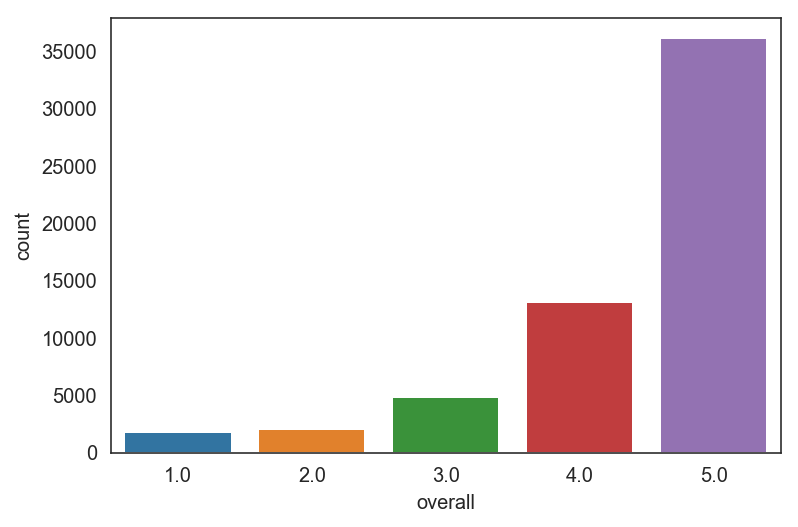

In [18]:
sns.countplot(reviews20['overall'])

### 3.3 Split Train and Test Sets
- Train: All ratings given before 2014
- Test: All ratings given in 2014
- Preprocessing: remove all products/users that only occurred in 2014. This is because we would have no 'training' data on them, and won't be able to predict their ratings

In [19]:
def remove_test_year_entries(df, test_year=2014):
    
    # remove all products/users that only started in 2014
    df['Year'] = df['reviewTime'].apply(lambda x: x.year)

    user_start_date = df.groupby('reviewerID')['Year'].min()
    df = df[df['reviewerID'].isin(user_start_date[user_start_date!=test_year].index)]

    product_start_date = df.groupby('asin')['Year'].min()
    df = df[df['asin'].isin(product_start_date[product_start_date!=test_year].index)]

    print(df.shape)
    
    return df

In [20]:
reviews20 = remove_test_year_entries(reviews20)

(52627, 9)


In [21]:
reviews20 = reviews20.sort_values(by='Year').reset_index(drop=True)
reviews20

,reviewerID,asin,reviewerName,productTitle,overall,summary,reviewText,reviewTime,Year
0,A281NPSIMI1C2R,B00004SPEU,"Rebecca of Amazon ""The Rebecca Review""",KRUPS F20342 Electric Spice and Coffee Grinder...,5.0,I use mine to grind spices :),I guess since I am not using this product ever...,2000-12-17,2000
1,A281NPSIMI1C2R,B00004SPZV,"Rebecca of Amazon ""The Rebecca Review""",Misto Brushed Aluminum Olive Oil Sprayer,3.0,"Good, but a bit of work ;)",When I first filled this sprayer and gave it a...,2000-11-20,2000
2,A281NPSIMI1C2R,B00000JGRT,"Rebecca of Amazon ""The Rebecca Review""",Cuisinart ICE-20 Automatic 1-1/2-Quart Ice Cre...,5.0,Ice Cream keeps us warm in winter?,"After several failed attempts, I began to wond...",2000-09-28,2000
3,A3A15L96IYUO6V,B00004OCJW,Michael Smith,OXO Good Grips Soft Handled Can Opener,5.0,Great can opener,This is a great and easy to use can opener. Th...,2000-05-26,2000
4,ALR35EFI69S5R,B00004OCKO,"Barron Laycock ""Labradorman""","OXO Good Grips Winged Corkscrew, Black",5.0,"Quick, Easy &amp; Effective help For WIne Klut...",My lady friend got me a couple of these recent...,2000-08-04,2000
5,A281NPSIMI1C2R,B00004S7YH,"Rebecca of Amazon ""The Rebecca Review""",Wilton 2104-7778 Master Tip Set,4.0,The perfect basic set!,I love this set of decorating tips. The only ...,2000-10-06,2000
6,A1KXONFPU2XQ5K,B00004S9BY,Stephanie Manley,Cuisinart BDH-2 Blade and Disc Holder,4.0,Nice addition to food processor.,This is a handy addition to the food processor...,2000-09-05,2000
7,A1RPTVW5VEOSI,B00004OCKG,Michael J. Edelman,OXO Good Grips Locking Can Opener,5.0,"Yes, a can opener you can get excited about!",Who'd think a cheap kitchen tool could excite ...,2000-05-04,2000
8,A1QPAGGX9FDQXM,B00004SGF0,Michela,KitchenAid KHM5DH 5-Speed Ultra Power Hand Mix...,5.0,Best Choice for Hand Mixer,When it was time for me to buy a new hand mixe...,2000-12-23,2000
9,A2TXMYYGSZCSZ1,B00004OCL8,"annie ""grannieannie""",OXO Good Grips Flexible Spatula,5.0,A Must Have for All Cookie Bakers!,This is the spatula you've been looking for! ...,2000-11-12,2000


In [22]:
check_matrix_sparsity(reviews)

No. of unique users:  66519
No. of unique products:  28237
Size of utility matrix: 66519 x 28237; 1878297003 cells
Sparsity: 0.029%


In [23]:
check_matrix_sparsity(reviews20)

No. of unique users:  2616
No. of unique products:  6412
Size of utility matrix: 2616 x 6412; 16773792 cells
Sparsity: 3.289%


In [152]:
reviews20['Year'].min()

2000

In [148]:
reviews20.shape

(52627, 9)

In [24]:
# split train and test
reviews20.head()

,reviewerID,asin,reviewerName,productTitle,overall,summary,reviewText,reviewTime,Year
0,A281NPSIMI1C2R,B00004SPEU,"Rebecca of Amazon ""The Rebecca Review""",KRUPS F20342 Electric Spice and Coffee Grinder...,5.0,I use mine to grind spices :),I guess since I am not using this product ever...,2000-12-17,2000
1,A281NPSIMI1C2R,B00004SPZV,"Rebecca of Amazon ""The Rebecca Review""",Misto Brushed Aluminum Olive Oil Sprayer,3.0,"Good, but a bit of work ;)",When I first filled this sprayer and gave it a...,2000-11-20,2000
2,A281NPSIMI1C2R,B00000JGRT,"Rebecca of Amazon ""The Rebecca Review""",Cuisinart ICE-20 Automatic 1-1/2-Quart Ice Cre...,5.0,Ice Cream keeps us warm in winter?,"After several failed attempts, I began to wond...",2000-09-28,2000
3,A3A15L96IYUO6V,B00004OCJW,Michael Smith,OXO Good Grips Soft Handled Can Opener,5.0,Great can opener,This is a great and easy to use can opener. Th...,2000-05-26,2000
4,ALR35EFI69S5R,B00004OCKO,"Barron Laycock ""Labradorman""","OXO Good Grips Winged Corkscrew, Black",5.0,"Quick, Easy &amp; Effective help For WIne Klut...",My lady friend got me a couple of these recent...,2000-08-04,2000


In [25]:
reviews20_pre2014 = reviews20[reviews20['Year'] != 2014]
reviews20_2014 = reviews20[reviews20['Year'] == 2014]

In [26]:
# checking if by removing 2014 users, are my product columns still the same? 

print('No. of products before 2014: ', len(set(reviews20_pre2014['asin'])))
print('No. of products in 2014: ', len(set(reviews20_2014['asin'])))
print('Subset? ', set(reviews20_2014['asin']).issubset(set(reviews20_pre2014['asin'])))

No. of products before 2014:  6412
No. of products in 2014:  3324
Subset?  True


### 3.4 Creating lookup dictionaries to match user-products and product-users
This is to help in the retrieval of products bought by users

In [27]:
# create a dictionary of user: products
user_products_train = {}

for row in reviews20_pre2014[['reviewerID','productTitle']].itertuples():
    user_products_train.setdefault(row[1], set())
    user_products_train[row[1]].add(row[2])
    
user_products_test = {}
for row in reviews20_2014[['reviewerID','productTitle']].itertuples():
    user_products_test.setdefault(row[1], set())
    user_products_test[row[1]].add(row[2])

In [28]:
# create another dictionary of products: users
product_users_train = {}

for row in reviews20_pre2014[['reviewerID','productTitle']].itertuples():
    product_users_train.setdefault(row[2], set())
    product_users_train[row[2]].add(row[1])
    
product_users_test = {}

for row in reviews20_2014[['reviewerID','productTitle']].itertuples():
    product_users_test.setdefault(row[2], set())
    product_users_test[row[2]].add(row[1])

### 3.5 Dropping irrelevant columns for modelling

In [29]:
reviews20_pre2014 = reviews20[reviews20['Year'] != 2014][['reviewerID','asin','overall']]
reviews20_2014 = reviews20[reviews20['Year'] == 2014][['reviewerID','asin','overall']]

### 3.6 Generating User-Item Utility Matrix

In [30]:
user_utility_matrix = reviews20_pre2014.pivot_table(values='overall',index='reviewerID',columns='asin')
user_utility_matrix.head()

asin,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N5FO,B00002N5Z9,B00002N5ZB,B00002N601,B00002N602,B00002N6SQ,...,B00GEGHNZE,B00GSXFKYY,B00GTCAY04,B00H1HYZ9C,B00H1OUSD2,B00H5EZ982,B00H5F3GRW,B00I4V1U06,B00JM3VFVE,B00KQJ42CW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100L918633LUO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1027WM3PXKVMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103BJIOJSDJL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Modelling

<a id='4.1.2'></a>
#### 4.1.2 User-User Collaborative Filtering with Surprise Library

In [31]:
def generate_predicted_ratings_matrix(utility_matrix):
    """
    Predict ratings for every product-user combination in the train set with a given Surprise model (algo)
    """
    predicted_ratings_matrix = (utility_matrix.fillna(0).stack().to_frame()
                                .apply(lambda x: algo.predict(x.name[0], x.name[1]).est, axis=1).unstack())

    return predicted_ratings_matrix

In [32]:
def generate_recommendations(user_id, pred_matrix, n_recommended_items, 
                             return_recommendations_only=False, print_results=True):
    
    sorted_items = list(pred_matrix.T[user_id].sort_values().index)
    
    recommended_items = []
    
    while len(recommended_items) < n_recommended_items:
        item = product_lookup[sorted_items.pop()]
        if item not in user_products_train[user_id]:
            recommended_items.append(item)
    
    user_purchase_history = user_products_train[user_id]
    user_actual_purchase = user_products_test[user_id]
    
    if print_results == True:
        print("==== User's Purchase History ====")
        for item in user_purchase_history:
            print(item)

        print("\n==== User's Actual Purchase in 2014 ====")
        for item in user_actual_purchase:
            print(item)   
            
        print("\n==== Model's Top 10 Recommendations ====")
        for item in recommended_items:
            print(item)
    
    if return_recommendations_only == True:
        return recommended_items
    else:
        return recommended_items, user_purchase_history, user_actual_purchase

In [33]:
def calculate_rmse(test_df):
    
    preds = test_df.copy()
    preds['predicted'] = preds.apply(lambda row: algo.predict(row['reviewerID'],row['asin'])[3], axis=1)
    
    rmse = np.sqrt(mean_squared_error(preds['overall'], preds['predicted']))
    
    return rmse, preds

In [34]:
def model_evaluation_recall(user_id, recommended_list):
    """
    Returns the number/proportion of the model's recommended items that the user actually bought in the test set
    Returns the proportion of the test set that was recommended by the model
    (test & rec) / test
    """
    item_intersection_count = len(set(recommended_list) & user_products_test[user_id])
    
    pct_recall = item_intersection_count / len(user_products_test[user_id])
    
    return pct_recall

In [67]:
def model_evaluation_recall_cat(rec, actual, verbose=False):
    
    rec_categories = set([category_lookup_short[item] for item in rec])
    actual_categories = set([category_lookup_short[item] for item in actual])
    
    overlap = rec_categories & actual_categories
    pct_recall = len(overlap)/len(rec)
    
    if verbose==True:
        print(overlap)
    
    return pct_recall

In [65]:
def hybrid_recommendations(user_id, perc_svd=0.3, return_recommendations_only=False):
    uu_rec, history, actual = generate_recommendations(user_id, 
                                                       pred_matrix = uucf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                       n_recommended_items = int(10*(1-perc_svd)),
                                                       return_recommendations_only=False,
                                                       print_results=False)
    
    svd_rec = generate_recommendations(user_id, 
                                       pred_matrix = svd_k40reg_predicted_ratings_matrix,
                                       n_recommended_items = int(10*perc_svd),
                                       return_recommendations_only=True,
                                       print_results=False)
    
    final_rec = uu_rec + svd_rec
    
    if return_recommendations_only==False:
        return final_rec, history, actual
    else: 
        return final_rec

In [59]:
def items_with_categories(list_of_products, user_id, pred_matrix, list_type='actual'):
    
    def categories_to_columns(row, cat_level):
        try:
            return row[cat_level]
        except IndexError:
            return np.nan
        
    def get_product_id(product_name):
        return metadata[metadata['title']==product_name]['asin'].values[0]
    
    rec_cat = pd.DataFrame([[item, category_lookup[item]] for item in list_of_products], 
                           columns=['Product Names', 'Category Path'])
    
    rec_cat['Category Path'] = rec_cat['Category Path'].apply(
        lambda x: [cat.strip() for cat in re.sub('[\[\]\'\"]', '', x).split(',')])
    
    rec_cat['cat_1'] = rec_cat['Category Path'].apply(lambda x: categories_to_columns(x,1))

    for i in range(1, 7):
        rec_cat['cat_'+str(i)] = rec_cat['Category Path'].apply(lambda x: categories_to_columns(x, i-1))
    
    rec_cat = rec_cat[['Product Names', 'cat_2', 'cat_3', 'cat_4']].sort_values(by=['cat_2','cat_3','cat_4'])
    
    if list_type == 'recommended':
        
        rec_cat['ratings'] = rec_cat['Product Names'].apply(lambda x: pred_matrix.T[user_id][get_product_id(x)])
        return rec_cat.sort_values(by='ratings', ascending=False)
    
    elif list_type == 'actual':
        rec_cat['ratings'] = rec_cat['Product Names'].apply(lambda x: reviews20[(reviews20['productTitle']==x) & 
                                                                                (reviews20['reviewerID']==user_id)]['overall'].values[0])
        return rec_cat

In [60]:
def n_random_items(n):
    return np.random.choice(metadata['title'].unique(),n)

In [61]:
def print_product_images(product_list):
    for item in product_list:
        print('=== {} ==='.format(item))
        display(Image(url=imgurl_lookup[item]))

# Testing all models

## UUCF, k=3, Pearson similarity

In [91]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=3, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [92]:
uucf_k3_pearson_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [93]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

1.0060736510510646

In [94]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         uucf_k3_pearson_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.009047365620010643
Avg hit rate: 0.2833134142239754 ± 0.3023293818139499


In [95]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        uucf_k3_pearson_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.26450239489089944
Avg hit rate: 0.12092555331991954 ± 0.050795963128645115


In [96]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                uucf_k3_pearson_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [97]:
print_product_images(rec)

=== Martex Bath Towels, White, 6-Pack ===


=== Oster BRLY07-B 7-Speed Fusion Blender, Black ===


=== Sleep Joy 3&quot; ViscO2 Ventilated Memory Foam Mattress Topper, Twin ===


=== Whitmor 6070-267 Supreme 5-Tier Shelving Unit, Black ===


=== Farberware Classic Stainless Steel 8-Inch and 10-Inch Skillet Twin Pack ===


=== Replacement Filters for Aeropress (350 pk) ===


=== Bormioli Rocco Quattro Stagioni Dipping Bowls, Set of 6, Gift Boxed ===


=== Rada Cutlery R129 Chef's Dicer with Aluminum Handle ===


=== Miracle Blade III Perfection Series 11-Piece Cutlery Set ===


=== Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2 ===


## UUCF, k=3, Pearson baseline similarity

In [98]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=3, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [99]:
uucf_k3_pearsonbaseline_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [100]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

1.0166267257410315

In [101]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         uucf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.008515167642362959
Avg hit rate: 0.1822964362026862 ± 0.1197534046044854


In [102]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        uucf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.271953166577967
Avg hit rate: 0.1199608610567515 ± 0.04798073686409777


In [103]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                uucf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [104]:
print_product_images(rec)

=== Martex Bath Towels, White, 6-Pack ===


=== Replacement Filters for Aeropress (350 pk) ===


=== Rada Cutlery R129 Chef's Dicer with Aluminum Handle ===


=== Miracle Blade III Perfection Series 11-Piece Cutlery Set ===


=== Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2 ===


=== Norpro Coffee Grinder ===


=== Hamilton Beach 70450 8-Cup Food Processor ===


=== Oster BRLY07-B 7-Speed Fusion Blender, Black ===


=== Command Medium Picture-Hanging Strips, 6-Picture ===


=== Holmes Heater Fan with 1Touch Control and ALCI Safe Plug, HFH442-UM ===


## UUCF, k=20, Pearson baseline similarity

In [105]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [106]:
uucf_k20_pearsonbaseline_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [107]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

1.016544800005623

In [108]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         uucf_k20_pearsonbaseline_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.009579563597658328
Avg hit rate: 0.16576903035236368 ± 0.10849385650185411


In [109]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        uucf_k20_pearsonbaseline_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.26663118680149017
Avg hit rate: 0.11896207584830341 ± 0.04664085997538797


In [110]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                uucf_k20_pearsonbaseline_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [111]:
print_product_images(rec)

=== Martex Bath Towels, White, 6-Pack ===


=== Replacement Filters for Aeropress (350 pk) ===


=== Rada Cutlery R129 Chef's Dicer with Aluminum Handle ===


=== Miracle Blade III Perfection Series 11-Piece Cutlery Set ===


=== Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2 ===


=== Norpro Coffee Grinder ===


=== Hamilton Beach 70450 8-Cup Food Processor ===


=== Oster BRLY07-B 7-Speed Fusion Blender, Black ===


=== Command Medium Picture-Hanging Strips, 6-Picture ===


=== Holmes Heater Fan with 1Touch Control and ALCI Safe Plug, HFH442-UM ===


## IICF, k=3, Pearson baseline similarity

In [112]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=3, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [114]:
iicf_k3_pearsonbaseline_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [115]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

1.0762176167359827

In [116]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         iicf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.004789781798829164
Avg hit rate: 0.2300112930547713 ± 0.28133104148241456


In [117]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        iicf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.17828632251197446
Avg hit rate: 0.1208955223880597 ± 0.04928538105687264


In [118]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                iicf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [119]:
print_product_images(rec)

=== Closet Complete Twirling Tie Rack / Hanger Organizer ===


=== Medelco RK202 One All Universal Single-Cup Replacement Coffee Filter, Set of 2 ===


=== Wilton Recipe Right 13 x 9 Inch Oblong Pan ===


=== Command Mounting Refill Strips, Large, 6-Strip ===


=== Hamilton Beach 26020 Belgian Style Waffle Baker ===


=== Wilton Recipe Right 8 Inch Square Pan ===


=== FoodSaver V3020 Vertical Vacuum Sealing System With Starter Kit ===


=== Folding Bread Proofer and Yogurt Maker ===


=== Frigidaire FRA054XT7 5,000 BTU Window-Mounted Mini Room Air Conditioner ===


=== Wilton Recipe Right 11 Inch x 7 Inch Biscuit Brownie Pan ===


## SVDreg, k=10

In [120]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = SVD(n_factors=10, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

In [121]:
svd_k10reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [122]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

0.9485948895709465

In [123]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         svd_k10reg_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.015965939329430547
Avg hit rate: 0.19250211399298625 ± 0.1835309949590267


In [124]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k10reg_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.2687599787120809
Avg hit rate: 0.1221782178217822 ± 0.054347688163389515


In [125]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                svd_k10reg_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [126]:
print_product_images(rec)

=== Breville BOV800XL Smart Oven 1800-Watt Convection Toaster Oven with Element IQ ===


=== PUR CR-6000 7-Cup Water Filtration Pitcher ===


=== Global Distinctions Buy-One-Get-One-Free Ottoman Set, Black ===


=== Umbra Casa Tissue Box Cover, White ===


=== Freshware 12-Cavity Silicone Petite Loaf Pan ===


=== Eureka EasyClean Corded Hand-Held Vacuum, 71B ===


=== Adagio Teas 16 oz. ingenuiTEA Bottom-Dispensing Teapot ===


=== nan ===


=== Natural Comfort White Down Alternative Comforter with Embossed Microfiber Cover, Light Weight Filled, King ===


=== Jumbl 1500-Watt Hand-Held Garment Steamer with Travel Pouch and Accessories ===


## SVDnoreg, k=40

In [127]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = SVD(n_factors=40)
algo.fit(trainset)

In [128]:
svd_k40_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [129]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

0.9410105261781494

In [130]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         svd_k40_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.017562533262373604
Avg hit rate: 0.18697959060765623 ± 0.134217538706749


In [131]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.25651942522618415
Avg hit rate: 0.129045643153527 ± 0.0571334790751041


In [132]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                svd_k40_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [133]:
print_product_images(rec)

=== Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle ===


=== DreamFoam Bedding 8-Inch Memory Foam Bed, Queen ===


=== OXO Good Grips 3-Quart Stainless Steel Colander ===


=== Thermos Stainless-Steel Vacuum Insulated Bottle ===


=== OXO Good Grips Stainless Steel Over-The-Door Hook ===


=== Japanese Rice Washing Bowl with Side and Bottom Drainers ===


=== USA Pans 13 x 4 x 4 Inch Pullman, Aluminized Steel with Americoat ===


=== Baker's Edge Nonstick Edge Brownie Pan ===


=== OXO Good Grips Clean Cut Pizza Wheel ===


=== Fox Run Silicone Baking Mat, 11-3/4 by 16-Inch ===


## SVDreg, k=40

In [134]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

In [135]:
svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [136]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

0.9509224818730287

In [137]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         svd_k40reg_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.009047365620010643
Avg hit rate: 0.37397504456327985 ± 0.20018305462628175


In [138]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24108568387440127
Avg hit rate: 0.12141280353200883 ± 0.05563789832577524


In [139]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                svd_k40reg_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [140]:
print_product_images(rec)

=== Kitchenaid Classic Shears With Soft Grip, Black ===


=== Fornuft Casual Flatware Silverware 20 Piece Set ===


=== Rada Cutlery French Chefs Knife, Made in USA, Aluminum Handle (R131) ===


=== OXO Good Grips Smooth Potato Masher ===


=== Mr. Coffee JWX9 5-Cup Programmable Coffeemaker, Black with Stainless Steel Carafe ===


=== Black &amp; Decker S700E ScumBuster Xtreme Cleaning Tool with 3-in-1 Extension Handle ===


=== Fox Run Butter Spreader Stick ===


=== Norpro 615 Jelly Strainer Bags, 2 Piece Set ===


=== Big Boss Rapid Wave Halogen Infrared Convection Countertop Oven - 12 &frac12; Quart with Extender Ring Glass Bowl ===


=== Grayline 40232 Deluxe Wrap Rack ===


## SVDreg, k=100

In [141]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = SVD(n_factors=100, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

In [142]:
svd_k100reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [143]:
rmse, preds = calculate_rmse(reviews20_2014)
rmse

0.9536859181624554

In [144]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         svd_k100reg_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.005854177754124534
Avg hit rate: 0.16196581196581195 ± 0.08268294600961273


In [145]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k100reg_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24215007982969664
Avg hit rate: 0.1197802197802198 ± 0.046456360758207825


In [146]:
rec, history, actual = generate_recommendations('A1S3C5OFU508P3',
                                                svd_k100reg_predicted_ratings_matrix,
                                                10,
                                                return_recommendations_only=False,
                                                print_results=False)

In [147]:
print_product_images(rec)

=== Zevro Dual Dry Food Dispenser, Black/Chrome ===


=== Cuisinart Dual-Sandwich Nonstick Electric Grill ===


=== Bodum Latte Battery Operated Milk Frother and Light Mixer with Plastic Beaker, 0.2 L, 6-Ounce, Off White ===


=== Fat Daddio's Anodized Aluminum Sheet Cake Pan, 14 Inch x 22 Inch x 3 Inch ===


=== Progressive International Perfect Prep and Breading Trays ===


=== Dyson DC24 Animal Compact Upright Vacuum Cleaner ===


=== Helen Chen's Asian Kitchen 14-inch Carbon Steel Wok with Bamboo Handles ===


=== DogBones NeckBones Neck Pillow, Evergreen ===


=== Catskill Craftsmen 12-Inch Tempered Glass Cutting Board with Padded Feet ===


=== Luminarc Nuance 10.5-Ounce Goblet, Set of 12 ===


## Random 10 Products Recall

In [150]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    random_items = list(n_random_items(10))
    
    user_recall = model_evaluation_recall(user, random_items)
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.0037253858435337944
Avg hit rate: 0.4004586683158111 ± 0.3864091837480371


In [151]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        _, history, actual = generate_recommendations(user, 
                                                        uucf_k3_pearson_predicted_ratings_matrix,
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)
        rec = list(n_random_items(10))

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24853645556146886
Avg hit rate: 0.11755888650963599 ± 0.045245396340187975


# FINAL MODEL

In [65]:
def hybrid_recommendations(user_id, perc_svd=0.3, return_recommendations_only=False):
    uu_rec, history, actual = generate_recommendations(user_id, 
                                                       pred_matrix = uucf_k3_pearsonbaseline_predicted_ratings_matrix,
                                                       n_recommended_items = int(10*(1-perc_svd)),
                                                       return_recommendations_only=False,
                                                       print_results=False)
    
    svd_rec = generate_recommendations(user_id, 
                                       pred_matrix = svd_k40reg_predicted_ratings_matrix,
                                       n_recommended_items = int(10*perc_svd),
                                       return_recommendations_only=True,
                                       print_results=False)
    
    final_rec = uu_rec + svd_rec
    
    if return_recommendations_only==False:
        return final_rec, history, actual
    else: 
        return final_rec

In [35]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=3, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [36]:
uucf_k3_pearson_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [37]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews20_pre2014[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(k=3, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [38]:
uucf_k3_pearsonbaseline_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [40]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

In [41]:
svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [56]:
user_tmp = 'A1027WM3PXKVMR'

In [57]:
rec, history, actual = hybrid_recommendations('A1S3C5OFU508P3')

['Martex Bath Towels, White, 6-Pack', 'Replacement Filters for Aeropress (350 pk)', "Rada Cutlery R129 Chef's Dicer with Aluminum Handle", 'Miracle Blade III Perfection Series 11-Piece Cutlery Set', "Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2", 'Norpro Coffee Grinder', 'Hamilton Beach 70450 8-Cup Food Processor']
['Honey-Can-Do SRT-01602 Kids Toy Organizer and Storage Bins, Natural/Primary', 'Cuisinart CPC-600 1000-Watt 6-Quart Electric Pressure Cooker, Brushed Stainless and Matte Black', 'Bormioli Rocco Gelo 2-Piece Glass Pitcher Set with Lids, Red and Green']


In [58]:
rec

['Martex Bath Towels, White, 6-Pack',
 'Replacement Filters for Aeropress (350 pk)',
 "Rada Cutlery R129 Chef's Dicer with Aluminum Handle",
 'Miracle Blade III Perfection Series 11-Piece Cutlery Set',
 "Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2",
 'Norpro Coffee Grinder',
 'Hamilton Beach 70450 8-Cup Food Processor',
 'Honey-Can-Do SRT-01602 Kids Toy Organizer and Storage Bins, Natural/Primary',
 'Cuisinart CPC-600 1000-Watt 6-Quart Electric Pressure Cooker, Brushed Stainless and Matte Black',
 'Bormioli Rocco Gelo 2-Piece Glass Pitcher Set with Lids, Red and Green']

In [62]:
print_product_images(rec)

=== Martex Bath Towels, White, 6-Pack ===


=== Replacement Filters for Aeropress (350 pk) ===


=== Rada Cutlery R129 Chef's Dicer with Aluminum Handle ===


=== Miracle Blade III Perfection Series 11-Piece Cutlery Set ===


=== Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2 ===


=== Norpro Coffee Grinder ===


=== Hamilton Beach 70450 8-Cup Food Processor ===


=== Honey-Can-Do SRT-01602 Kids Toy Organizer and Storage Bins, Natural/Primary ===


=== Cuisinart CPC-600 1000-Watt 6-Quart Electric Pressure Cooker, Brushed Stainless and Matte Black ===


=== Bormioli Rocco Gelo 2-Piece Glass Pitcher Set with Lids, Red and Green ===


In [66]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, hybrid_recommendations(user,return_recommendations_only=True))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.007450771687067589
Avg hit rate: 0.17846350078492934 ± 0.1255955202068005


In [67]:
def model_evaluation_recall_cat(rec, actual, verbose=False):
    
    rec_categories = set([category_lookup_short[item] for item in rec])
    actual_categories = set([category_lookup_short[item] for item in actual])
    
    overlap = rec_categories & actual_categories
    pct_recall = len(overlap)/len(rec)
    
    if verbose==True:
        print(overlap)
    
    return pct_recall

In [76]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = hybrid_recommendations(user,return_recommendations_only=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.26663118680149017
Avg hit rate: 0.12315369261477048 ± 0.0507708476725625


In [79]:
rec, history, actual = hybrid_recommendations('AJT2XS3UJ9WIK')

In [80]:
print_product_images(rec)

=== Lock &amp; Lock Storage 1 Gallon Large Pitcher ===


=== Sleep Better Iso-Cool Memory Foam Pillow, Gusseted Side Sleeper ,Standard ===


=== Dyson DC50 Animal Compact Upright Vacuum Cleaner ===


=== Soft Heat Micro-Plush Top Low-Voltage Electric Heated Twin Mattress Pad, White ===


=== Rada Cutlery R141 Deluxe Vegetable Peeler with Aluminum Handle ===


=== WearEver C943SA64 Pure Living Nonstick Ceramic Coating PTFE-PFOA-Cadmium Free Dishwasher Safe 10 Piece Cookware Set, Red ===


=== Cathay Home Fashions Luxury Silky Soft Brushed Microfiber Twin Sheet Set, Burgundy ===


=== Oneida Mooncrest 45-Piece Flatware Set, Service for 8 ===


=== YouCopia Super SpiceStack 27-Bottle Spice Organizer, White ===


=== Sunbeam 3910-100 2-Slice Wide Slot Toaster, Black ===


In [81]:
rec, history, actual = hybrid_recommendations('A2D1PTMMCA93BV')

In [82]:
print_product_images(rec)

=== Proctor-Silex 75217F Power Can Opener Black ===


=== Bormioli Rocco Verdi Cappuccino Cup with Stainless Steel Handle, Set of 4, Gift Boxed ===


=== Debbie Meyer GreenBags, 20-Pack ===


=== KitchenAid KHM7T 7-Speed Artisan Hand Mixer, White ===


=== BISSELL SpotLifter 2X Portable Deep Carpet Cleaner, 1719 ===


=== OXO Good Grips 4-Cup Fat Separator ===


=== Black and Decker SL5470C Stainless Steel Slow Cooker ===


=== Ateco 14406 6-Inch Round Stainless Steel Cutter ===


=== Reflections 52 by 52-Inch Tablecloth, Khaki ===


=== Winsome Capri Foldable Fabric Baskets, Set of 4, Black ===


In [ ]:
def hybrid_recommendations_items(item_set):
    
    # with surprise:
    ## create new similarity matrix with new user
    ## call algo.predict on each new-user, item combo (6000 predictions)
    ##generate recommendations for just that user
    
    # how to do this with surprise?
    

In [64]:
uucf_k3_recommendations, uucf_k3_user_purchase_history, uucf_k3_user_actual_purchase = generate_recommendations(user_tmp, 
                                                                                                pred_matrix=uucf_k3_predicted_ratings_matrix, 
                                                                                                n_recommended_items=10)
uucf_k3_recommendations

==== User's Purchase History ====
Victorinox Cutlery 9-Inch Wavy Edge Bread Knife, Black Polypropylene Handle
Norpro Corn Butter Spreader
FoodSaver 11&quot; Roll, 2pk
Norpro Stainless-Steel Holder with Cotton Cooking Twine, 220 feet
Misto Brushed Aluminum Olive Oil Sprayer
Lodge L4LP3 Loaf Pan
Ronco ST5000PLGEN Showtime Rotisserie Platinum Edition
EatSmart Precision Pro Digital Kitchen Scale, Silver
Breville BOV800XL Smart Oven 1800-Watt Convection Toaster Oven with Element IQ
Epica Stainless Steel Compost Bin 1 Gallon
Best Manufacturers Flour Duster
Trudeau Porcelain Butter Boat

==== User's Actual Purchase in 2014 ====
Lodge L5MIC3 Miniature Lid
Lodge LMP3 Pre-Seasoned Cast-Iron Melting Pot, 14-Ounce
Lodge Pro-Logic P14P3 Cast Iron Pizza Pan, Black, 14-inch
Lodge Color EC3D43 Enameled Cast Iron Dutch Oven, Island Spice Red, 3-Quart
OXO Good Grips Solid Stainless Steel Ice Cream Scoop
Calphalon Easy Grip Apple Slicer
Zojirushi BB-PAC20 Home Bakery Virtuoso Breadmaker 120 Volts
The Rin

['Breville BTM800XL One-Touch Tea Maker',
 'Shun DM0700 Classic 3-1/2-Inch Paring Knife',
 'Shun DM0718 Classic 7-Inch Santoku Hollow Ground Knife',
 'OXO Good Grips Splatter Screen with Folding Handle',
 'MIU France Set of 2 Silicone Pot Holders, Red',
 'Wilton 6-Cavity Silicone Heart Mold Pan',
 'Shun DM0750 Honing Steel',
 'Freshware 30-Cavity Silicone Chocolate, Candy and Peanut Butter-Cup Mold',
 'Soy Sauce Container -15 pcs in a Bag.',
 'Shun DM0741 Classic U2 (Ultimate Utility) Knife']

In [65]:
# if data is whole reviews dataset, rmse is actually 0.66!
# but after changing to just my defined training data of pre2014, I get 0.94 which is more realistic

uucf_k3_rmse, uucf_k3_preds = calculate_rmse(reviews20_2014)

In [66]:
print(uucf_k3_rmse)
uucf_k3_preds.head()

1.0166267257410315


,reviewerID,asin,overall,predicted
44965,A32XMT8ULJ5CDV,B00004OCMX,5.0,2.000000
44966,A3DD96LN8U1NM,B00FHW8O22,3.0,3.416667
44967,A7ED6BJO320TG,B002S52ZDU,3.0,3.416667
44968,A3KNGMX2RVQG91,B0000CFDD5,4.0,4.761905
44969,A231D0MBFFEZK1,B002S52ZDU,4.0,4.222222


In [67]:
uucf_k3_recall = model_evaluation_recall(user_tmp, 
                                         generate_recommendations(user_tmp, 
                                                                  pred_matrix=uucf_k3_predicted_ratings_matrix, 
                                                                  n_recommended_items=10,
                                                                  return_recommendations_only=True, 
                                                                  print_results=False))
uucf_k3_recall

0.0

In [68]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         uucf_k3_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0:
        min_1_hit += 1
        hit_rates.append(user_recall)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.008515167642362959
Avg hit rate: 0.1822964362026862 ± 0.1197534046044854


[Back to Results Cell](#model-results)

## 4.2 Model-Based Collaborative Filtering Methods

### 4.2.1 Matrix Factorization with Singular Value Decomposition (SVD)

In [287]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

In [288]:
svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

### Visualising the Recommendations

In [118]:
def items_with_categories(list_of_products, user_id, pred_matrix, list_type='actual'):
    
    def categories_to_columns(row, cat_level):
        try:
            return row[cat_level]
        except IndexError:
            return np.nan
        
    def get_product_id(product_name):
        return metadata[metadata['title']==product_name]['asin'].values[0]
    
    rec_cat = pd.DataFrame([[item, category_lookup[item]] for item in list_of_products], 
                           columns=['Product Names', 'Category Path'])
    
    rec_cat['Category Path'] = rec_cat['Category Path'].apply(
        lambda x: [cat.strip() for cat in re.sub('[\[\]\'\"]', '', x).split(',')])
    
    rec_cat['cat_1'] = rec_cat['Category Path'].apply(lambda x: categories_to_columns(x,1))

    for i in range(1, 7):
        rec_cat['cat_'+str(i)] = rec_cat['Category Path'].apply(lambda x: categories_to_columns(x, i-1))
    
    rec_cat = rec_cat[['Product Names', 'cat_2', 'cat_3', 'cat_4']].sort_values(by=['cat_2','cat_3','cat_4'])
    
    if list_type == 'recommended':
        
        rec_cat['ratings'] = rec_cat['Product Names'].apply(lambda x: pred_matrix.T[user_id][get_product_id(x)])
        return rec_cat.sort_values(by='ratings', ascending=False)
    
    elif list_type == 'actual':
        rec_cat['ratings'] = rec_cat['Product Names'].apply(lambda x: reviews20[(reviews20['productTitle']==x) & 
                                                                                (reviews20['reviewerID']==user_id)]['overall'].values[0])
        return rec_cat

In [119]:
def n_random_items(n):
    return np.random.choice(metadata['title'].unique(),n)

In [120]:
def print_product_images(product_list):
    for item in product_list:
        print('=== {} ==='.format(item))
        display(Image(url=imgurl_lookup[item]))

#### user_tmp

In [162]:
rec_uucfk3, history, actual = generate_recommendations(user_tmp, uucf_k3_predicted_ratings_matrix, 10, False, False)

In [163]:
items_with_categories(history, user_tmp, uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
10,Best Manufacturers Flour Duster,Kitchen & Dining,Bakeware,Baking Tools & Accessories,5.0
5,Lodge L4LP3 Loaf Pan,Kitchen & Dining,Bakeware,Bread & Loaf Pans,5.0
11,Trudeau Porcelain Butter Boat,Kitchen & Dining,Dining & Entertaining,Serveware,5.0
0,Victorinox Cutlery 9-Inch Wavy Edge Bread Knif...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Bread & Serrated Knives,4.0
7,"EatSmart Precision Pro Digital Kitchen Scale, ...",Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,5.0
4,Misto Brushed Aluminum Olive Oil Sprayer,Kitchen & Dining,Kitchen Utensils & Gadgets,Oil Sprayers & Dispensers,2.0
3,Norpro Stainless-Steel Holder with Cotton Cook...,Kitchen & Dining,Kitchen Utensils & Gadgets,Tool & Gadget Sets,5.0
6,Ronco ST5000PLGEN Showtime Rotisserie Platinum...,Kitchen & Dining,Small Appliances,Ovens & Toasters,2.0
8,Breville BOV800XL Smart Oven 1800-Watt Convect...,Kitchen & Dining,Small Appliances,Ovens & Toasters,4.0
9,Epica Stainless Steel Compost Bin 1 Gallon,Kitchen & Dining,Storage & Organization,Compost Bins,5.0


In [164]:
print_product_images(history)

=== Victorinox Cutlery 9-Inch Wavy Edge Bread Knife, Black Polypropylene Handle ===


=== Norpro Corn Butter Spreader ===


=== FoodSaver 11&quot; Roll, 2pk ===


=== Norpro Stainless-Steel Holder with Cotton Cooking Twine, 220 feet ===


=== Misto Brushed Aluminum Olive Oil Sprayer ===


=== Lodge L4LP3 Loaf Pan ===


=== Ronco ST5000PLGEN Showtime Rotisserie Platinum Edition ===


=== EatSmart Precision Pro Digital Kitchen Scale, Silver ===


=== Breville BOV800XL Smart Oven 1800-Watt Convection Toaster Oven with Element IQ ===


=== Epica Stainless Steel Compost Bin 1 Gallon ===


=== Best Manufacturers Flour Duster ===


=== Trudeau Porcelain Butter Boat ===


In [165]:
items_with_categories(actual, user_tmp, uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
2,"Lodge Pro-Logic P14P3 Cast Iron Pizza Pan, Bla...",Kitchen & Dining,Bakeware,Pizza Pans & Stones,5.0
3,Lodge Color EC3D43 Enameled Cast Iron Dutch Ov...,Kitchen & Dining,Cookware,Dutch Ovens,5.0
8,Lodge Color EC4D33 Enameled Cast Iron Dutch Ov...,Kitchen & Dining,Cookware,Dutch Ovens,5.0
0,Lodge L5MIC3 Miniature Lid,Kitchen & Dining,Cookware,Lids,3.0
7,The Ringer Cast Iron Cleaner XL 8x6 Inch Stain...,Kitchen & Dining,Cookware,Skillets,5.0
1,"Lodge LMP3 Pre-Seasoned Cast-Iron Melting Pot,...",Kitchen & Dining,Cookware,Specialty Cookware,4.0
5,Calphalon Easy Grip Apple Slicer,Kitchen & Dining,Kitchen Utensils & Gadgets,Graters,3.0
4,OXO Good Grips Solid Stainless Steel Ice Cream...,Kitchen & Dining,Kitchen Utensils & Gadgets,Specialty Tools & Gadgets,5.0
9,Cuisinart HB-155PC Smart Stick Hand Blender wi...,Kitchen & Dining,Small Appliances,Blenders,4.0
6,Zojirushi BB-PAC20 Home Bakery Virtuoso Breadm...,Kitchen & Dining,Small Appliances,Bread Machines,5.0


In [166]:
print_product_images(actual)

=== Lodge L5MIC3 Miniature Lid ===


=== Lodge LMP3 Pre-Seasoned Cast-Iron Melting Pot, 14-Ounce ===


=== Lodge Pro-Logic P14P3 Cast Iron Pizza Pan, Black, 14-inch ===


=== Lodge Color EC3D43 Enameled Cast Iron Dutch Oven, Island Spice Red, 3-Quart ===


=== OXO Good Grips Solid Stainless Steel Ice Cream Scoop ===


=== Calphalon Easy Grip Apple Slicer ===


=== Zojirushi BB-PAC20 Home Bakery Virtuoso Breadmaker 120 Volts ===


=== The Ringer Cast Iron Cleaner XL 8x6 Inch Stainless Steel Chainmail ===


=== Lodge Color EC4D33 Enameled Cast Iron Dutch Oven, Caribbean Blue, 4.5-Quart ===


=== Cuisinart HB-155PC Smart Stick Hand Blender with Blending and Whisk Attachments ===


In [167]:
items_with_categories(rec_uucfk3, user_tmp, uucf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
5,Wilton 6-Cavity Silicone Heart Mold Pan,Kitchen & Dining,Bakeware,Candy Making Supplies,4.987705
7,"Freshware 30-Cavity Silicone Chocolate, Candy ...",Kitchen & Dining,Bakeware,Candy Making Supplies,4.987705
4,"MIU France Set of 2 Silicone Pot Holders, Red",Kitchen & Dining,Kitchen & Table Linens,Potholders & Oven Mitts,4.987705
2,Shun DM0718 Classic 7-Inch Santoku Hollow Grou...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Chefs Knives,4.987705
6,Shun DM0750 Honing Steel,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Knife Sharpeners,4.987705
1,Shun DM0700 Classic 3-1/2-Inch Paring Knife,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Paring Knives,4.987705
9,Shun DM0741 Classic U2 (Ultimate Utility) Knife,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Utility Knives,4.987705
3,OXO Good Grips Splatter Screen with Folding Ha...,Kitchen & Dining,Kitchen Utensils & Gadgets,Cooking Utensils,4.987705
0,Breville BTM800XL One-Touch Tea Maker,Kitchen & Dining,Small Appliances,Coffee,4.987705
8,Soy Sauce Container -15 pcs in a Bag.,Kitchen & Dining,Storage & Organization,Kitchen Storage & Organization Accessories,4.987705


In [168]:
print_product_images(rec_uucfk3)

=== Breville BTM800XL One-Touch Tea Maker ===


=== Shun DM0700 Classic 3-1/2-Inch Paring Knife ===


=== Shun DM0718 Classic 7-Inch Santoku Hollow Ground Knife ===


=== OXO Good Grips Splatter Screen with Folding Handle ===


=== MIU France Set of 2 Silicone Pot Holders, Red ===


=== Wilton 6-Cavity Silicone Heart Mold Pan ===


=== Shun DM0750 Honing Steel ===


=== Freshware 30-Cavity Silicone Chocolate, Candy and Peanut Butter-Cup Mold ===


=== Soy Sauce Container -15 pcs in a Bag. ===


=== Shun DM0741 Classic U2 (Ultimate Utility) Knife ===


#### User: 'A1S3C5OFU508P3'

In [416]:
rec_uucfk3, history, actual = generate_recommendations('A1S3C5OFU508P3', uucf_k3_pearson_predicted_ratings_matrix, 10, False, False)

In [172]:
items_with_categories(history, 'A1S3C5OFU508P3', uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
1,Cuissential SlickBoil: Collapsible Silicone Te...,Kitchen & Dining,Cookware,Teakettles,5.0
0,"Tea Beyond Heat resistant Glass Teapot Juliet,...",Kitchen & Dining,Dining & Entertaining,Serveware,5.0
2,Ice Ball Mold - Steal These MASSIVE Ice Ball M...,Kitchen & Dining,Home Brewing & Wine Making,Wine Making,5.0


In [173]:
print_product_images(history)

=== Tea Beyond Heat resistant Glass Teapot Juliet, 20-Ounce ===


=== Cuissential SlickBoil: Collapsible Silicone Tea Kettle (Red) ===


=== Ice Ball Mold - Steal These MASSIVE Ice Ball Makers * 70% OFF TODAY ONLY! * Try DeluxIce &copy; The Biggest, FREE from All Chemicals, #1 Rated Ice Ball Maker. Made with Extra-Thick Silicone, It Does Not Leak. Make HUGE 2.5 Inch Ice Cube Sphere Balls at Your Next Party. Perfect in Whiskey, Scotch, Wine, or Any Beverage, These Molds Make Round Spheres That Melt Slower than Tray Cubes. Our Customers LOVE This Item, And We Back It With A LIFETIME REPLACEMENT GUARANTEE.... Or Your Money Back! ===


In [174]:
items_with_categories(actual, 'A1S3C5OFU508P3', uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
1,Tea Beyond Teapot Fairy with Tea Warmer Cozy,Kitchen & Dining,Dining & Entertaining,Serveware,5.0
0,Smart Weigh GEM20 High Precision Digital Milli...,Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,5.0


In [175]:
print_product_images(actual)

=== Smart Weigh GEM20 High Precision Digital Milligram Scale 20 x 0.001g Ideal for Weighing Gems, Jewelry and other Precious Objects (Silver) ===


=== Tea Beyond Teapot Fairy with Tea Warmer Cozy ===


In [417]:
items_with_categories(rec_uucfk3, 'A1S3C5OFU508P3', uucf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
7,Clara Clark Premier 1800 Chain Design 4pc Bed ...,Bedding,Sheets & Pillowcases,Sheets,5.0
0,CIA 23304 Masters Collection 12 Inch x 17 Inch...,Kitchen & Dining,Bakeware,Baking Tools & Accessories,5.0
4,Vollrath 5220 Aluminum Wear-Ever Heavy-Duty 16...,Kitchen & Dining,Cookware,All Pans,5.0
3,Ball Jar Heritage Collection Pint Jars with Li...,Kitchen & Dining,Cookware,Canning,5.0
1,HIC 12- by 12-inch Celery Microfiber Dish Clot...,Kitchen & Dining,Kitchen & Table Linens,Dish Cloths & Dish Towels,5.0
6,HIC Librett Cotton Butchers Twine 370-Feet,Kitchen & Dining,Kitchen Utensils & Gadgets,Meat & Poultry Tools,5.0
9,AeroPress Coffee and Espresso Maker with Bonus...,Kitchen & Dining,Small Appliance Parts & Accessories,Coffee & Espresso Machine Parts & Accessories,5.0
2,Hamilton Beach 50242N WaveMaker 10-Speed Blend...,Kitchen & Dining,Small Appliances,Blenders,5.0
8,PUR 5 Cup Water Filter Pitcher CR-4000,Kitchen & Dining,Water Coolers & Filters,Pitcher Water Filters,5.0
5,Behrens 6110 10-Gallon Locking Lid Can,Storage & Organization,Baskets & Bins,Lidded Storage Bins,5.0


In [418]:
print_product_images(rec_uucfk3)

=== CIA 23304 Masters Collection 12 Inch x 17 Inch Wire Cooling Rack, Chrome Plate Steel ===


=== HIC 12- by 12-inch Celery Microfiber Dish Cloth, Set of 4 ===


=== Hamilton Beach 50242N WaveMaker 10-Speed Blender, Black ===


=== Ball Jar Heritage Collection Pint Jars with Lids and Bands, Set of 6 ===


=== Vollrath 5220 Aluminum Wear-Ever Heavy-Duty 16-Guage Closed Bead Natural Sheet Pan, 1/4 Size ===


=== Behrens 6110 10-Gallon Locking Lid Can ===


=== HIC Librett Cotton Butchers Twine 370-Feet ===


=== Clara Clark Premier 1800 Chain Design 4pc Bed Sheet Set - King Size, White ===


=== PUR 5 Cup Water Filter Pitcher CR-4000 ===


=== AeroPress Coffee and Espresso Maker with Bonus 350 Micro Filters ===


In [178]:
rec_iicfk3, history, actual = generate_recommendations('A1S3C5OFU508P3', iicf_k3_predicted_ratings_matrix, 10, False, False)

In [179]:
items_with_categories(rec_iicfk3, 'A1S3C5OFU508P3', iicf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
8,"Frigidaire FRA054XT7 5,000 BTU Window-Mounted ...",Heating,Cooling & Air Quality,Air Conditioners & Accessories,5.0
2,Wilton Recipe Right 13 x 9 Inch Oblong Pan,Kitchen & Dining,Bakeware,Cake Pans,5.0
5,Wilton Recipe Right 8 Inch Square Pan,Kitchen & Dining,Bakeware,Cake Pans,5.0
9,Wilton Recipe Right 11 Inch x 7 Inch Biscuit B...,Kitchen & Dining,Bakeware,Cake Pans,5.0
1,Medelco RK202 One All Universal Single-Cup Rep...,Kitchen & Dining,Small Appliance Parts & Accessories,Coffee & Espresso Machine Parts & Accessories,5.0
7,Folding Bread Proofer and Yogurt Maker,Kitchen & Dining,Small Appliances,Bread Machines,5.0
6,FoodSaver V3020 Vertical Vacuum Sealing System...,Kitchen & Dining,Small Appliances,Specialty Appliances,5.0
4,Hamilton Beach 26020 Belgian Style Waffle Baker,Kitchen & Dining,Small Appliances,Waffle Irons,5.0
0,Closet Complete Twirling Tie Rack / Hanger Org...,Storage & Organization,Clothing & Closet Storage,Hangers,5.0
3,"Command Mounting Refill Strips, Large, 6-Strip",Storage & Organization,Home Storage Hooks,Utility Hooks,5.0


In [181]:
print_product_images(rec_iicfk3)

=== Closet Complete Twirling Tie Rack / Hanger Organizer ===


=== Medelco RK202 One All Universal Single-Cup Replacement Coffee Filter, Set of 2 ===


=== Wilton Recipe Right 13 x 9 Inch Oblong Pan ===


=== Command Mounting Refill Strips, Large, 6-Strip ===


=== Hamilton Beach 26020 Belgian Style Waffle Baker ===


=== Wilton Recipe Right 8 Inch Square Pan ===


=== FoodSaver V3020 Vertical Vacuum Sealing System With Starter Kit ===


=== Folding Bread Proofer and Yogurt Maker ===


=== Frigidaire FRA054XT7 5,000 BTU Window-Mounted Mini Room Air Conditioner ===


=== Wilton Recipe Right 11 Inch x 7 Inch Biscuit Brownie Pan ===


In [182]:
rec_svdk100, history, actual = generate_recommendations('A1S3C5OFU508P3', svd_k100_predicted_ratings_matrix, 10, False, False)

In [183]:
items_with_categories(rec_svdk100, 'A1S3C5OFU508P3', svd_k100_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
4,Lodge L4LP3 Loaf Pan,Kitchen & Dining,Bakeware,Bread & Loaf Pans,5.000000
2,"Frieling Polished Stainless French Press, 23-O...",Kitchen & Dining,Coffee,Tea & Espresso,5.000000
0,Victorinox Fibrox 7-Inch Granton Edge Santoku ...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Bread & Serrated Knives,5.000000
1,"Kuhn Rikon 2710 Ultimate Shears, Black",Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Shears,5.000000
3,RSVP 6-Piece Stainless Steel Nesting Measuring...,Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,5.000000
5,Anolon Chef Clad Stainless Steel 10-Piece Cook...,Kitchen & Dining,Cookware,Cookware Sets,4.995768
6,Klip It 1250 Bakery Storage with Measure Cup,Kitchen & Dining,Storage & Organization,Food Savers,4.985766
7,OXO Good Grips Stainless Steel Over-The-Door Hook,Storage & Organization,Clothing & Closet Storage,Closet System Attachments,4.975771
8,Simplehuman Rechargeable Sensor Pump Soap Disp...,Bath,Bathroom Accessories,Holders & Dispensers,4.969680
9,OXO Good Grips Solid Stainless Steel Ice Cream...,Kitchen & Dining,Kitchen Utensils & Gadgets,Specialty Tools & Gadgets,4.968878


In [185]:
print_product_images(rec_svdk100)

=== Victorinox Fibrox 7-Inch Granton Edge Santoku Knife ===


=== Kuhn Rikon 2710 Ultimate Shears, Black ===


=== Frieling Polished Stainless French Press, 23-Ounce ===


=== RSVP 6-Piece Stainless Steel Nesting Measuring Cup Set ===


=== Lodge L4LP3 Loaf Pan ===


=== Anolon Chef Clad Stainless Steel 10-Piece Cookware Set ===


=== Klip It 1250 Bakery Storage with Measure Cup ===


=== OXO Good Grips Stainless Steel Over-The-Door Hook ===


=== Simplehuman Rechargeable Sensor Pump Soap Dispenser, 11 Fluid Ounce ===


=== OXO Good Grips Solid Stainless Steel Ice Cream Scoop ===


In [241]:
rec_svdppk20, history, actual = generate_recommendations('A1S3C5OFU508P3', svdpp_k20_predicted_ratings_matrix, 10, False, False)

In [242]:
items_with_categories(rec_svdppk20, 'A1S3C5OFU508P3', svdpp_k20_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
8,"InterDesign Med+, 12-Inch Drawer Caddy, Clear",Bath,Bathroom Accessories,Shower Accessories,5.0
5,Newpoint Home Deluxe 250-Thread-Count Cotton D...,Bedding,Mattress Pads,NaN,5.0
4,"Fox Run Silicone Baking Mat, 11-3/4 by 16-Inch",Kitchen & Dining,Bakeware,Baking Tools & Accessories,5.0
0,"Victorinox 47547 10-1/4-Inch Wavy Bread Knife,...",Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Bread & Serrated Knives,5.0
2,"Kuhn Rikon 2710 Ultimate Shears, Black",Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Shears,5.0
1,Rubbermaid Commercial FG1962000000 High-Heat S...,Kitchen & Dining,Kitchen Utensils & Gadgets,Cooking Utensils,5.0
9,OXO Good Grips Lua Pepper Mill,Kitchen & Dining,Kitchen Utensils & Gadgets,Salt & Pepper,5.0
6,Splash-Proof Super-Fast Thermapen (Red) Instan...,Kitchen & Dining,Kitchen Utensils & Gadgets,Thermometers & Timers,5.0
7,"Cuisinart DCC-RWF Replacement Water Filters, 2...",Kitchen & Dining,Small Appliance Parts & Accessories,Coffee & Espresso Machine Parts & Accessories,5.0
3,OXO Good Grips Stainless Steel Over-The-Door Hook,Storage & Organization,Clothing & Closet Storage,Closet System Attachments,5.0


In [243]:
print_product_images(rec_svdppk20)

=== Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle ===


=== Rubbermaid Commercial FG1962000000 High-Heat Scraper, 9.5-inch ===


=== Kuhn Rikon 2710 Ultimate Shears, Black ===


=== OXO Good Grips Stainless Steel Over-The-Door Hook ===


=== Fox Run Silicone Baking Mat, 11-3/4 by 16-Inch ===


=== Newpoint Home Deluxe 250-Thread-Count Cotton Damask Stripe Queen Mattress Pad ===


=== Splash-Proof Super-Fast Thermapen (Red) Instant Read Thermometer, Perfect for Barbecue, Home and Professional Cooking ===


=== Cuisinart DCC-RWF Replacement Water Filters, 2-Pack ===


=== InterDesign Med+, 12-Inch Drawer Caddy, Clear ===


=== OXO Good Grips Lua Pepper Mill ===


In [ ]:
svd_k40reg_predicted_ratings_matrix

In [406]:
rec_svdk40reg, history, actual = generate_recommendations('A1S3C5OFU508P3', svd_k40reg_predicted_ratings_matrix, 5, False, False)

In [407]:
items_with_categories(rec_svdk40reg, 'A1S3C5OFU508P3', svd_k40reg_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
0,CIA 23304 Masters Collection 12 Inch x 17 Inch...,Kitchen & Dining,Bakeware,Baking Tools & Accessories,4.779670
1,HIC 12- by 12-inch Celery Microfiber Dish Clot...,Kitchen & Dining,Kitchen & Table Linens,Dish Cloths & Dish Towels,4.736714
2,Hamilton Beach 50242N WaveMaker 10-Speed Blend...,Kitchen & Dining,Small Appliances,Blenders,4.730607
3,Ball Jar Heritage Collection Pint Jars with Li...,Kitchen & Dining,Cookware,Canning,4.729550
4,Vollrath 5220 Aluminum Wear-Ever Heavy-Duty 16...,Kitchen & Dining,Cookware,All Pans,4.726389


In [408]:
print_product_images(rec_svdk40reg)

=== CIA 23304 Masters Collection 12 Inch x 17 Inch Wire Cooling Rack, Chrome Plate Steel ===


=== HIC 12- by 12-inch Celery Microfiber Dish Cloth, Set of 4 ===


=== Hamilton Beach 50242N WaveMaker 10-Speed Blender, Black ===


=== Ball Jar Heritage Collection Pint Jars with Lids and Bands, Set of 6 ===


=== Vollrath 5220 Aluminum Wear-Ever Heavy-Duty 16-Guage Closed Bead Natural Sheet Pan, 1/4 Size ===


In [ ]:
#potentially for examples:
# A26K3T6L5NYO7L
# A2D1PTMMCA93BV

In [139]:
#shortlisted examples
# AJT2XS3UJ9WIK

#### User: 'AJT2XS3UJ9WIK'

In [186]:
rand_user = np.random.choice(reviews20['reviewerID'].unique(),1)[0]
print(rand_user)

A1X2373RW38LPT


In [217]:
rec_uucfk3, history, actual = generate_recommendations('AJT2XS3UJ9WIK', uucf_k3_predicted_ratings_matrix, 10, False, False)

In [218]:
items_with_categories(history, 'AJT2XS3UJ9WIK', uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
7,"Dream Supreme Plus Gel Fiber-Filled Pillows, K...",Bedding,Bed Pillows,Hypoallergenic Bed Pillows,3.0
5,Newpoint International 370-Thread Count Mercer...,Bedding,Mattress Pads,NaN,5.0
3,Divatex Home Fashions Royal Opulence Satin Cal...,Bedding,Sheets & Pillowcases,Sheet & Pillowcase Sets,5.0
4,Sleep Innovations 12-Inch SureTemp Memory Foam...,Furniture,Bedroom Furniture,Mattresses & Box Springs,5.0
2,"Winsome Wood Windsor Chair, Natural, Set of 2",Furniture,Kitchen & Dining Room Furniture,Chairs,5.0
6,Sunpentown SD-65E 65-Pint Dehumidifier,Heating,Cooling & Air Quality,Dehumidifiers & Accessories,3.0
0,OXO Good Grips 15-Inch-by-21-Inch Cutting Boar...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Cutting Boards,5.0
1,Nesco Snackmaster Pro Food Dehydrator FD-75A,Kitchen & Dining,Small Appliances,Specialty Appliances,3.0


In [219]:
print_product_images(history)

=== OXO Good Grips 15-Inch-by-21-Inch Cutting Board, Black ===


=== Nesco Snackmaster Pro Food Dehydrator FD-75A ===


=== Winsome Wood Windsor Chair, Natural, Set of 2 ===


=== Divatex Home Fashions Royal Opulence Satin Cal King Sheet Set, Ivory ===


=== Sleep Innovations 12-Inch SureTemp Memory Foam Mattress 20-Year Warranty, Twin ===


=== Newpoint International 370-Thread Count Mercerized Cotton Mattress Pad, Twin ===


=== Sunpentown SD-65E 65-Pint Dehumidifier ===


=== Dream Supreme Plus Gel Fiber-Filled Pillows, King (Set of 2) ===


In [220]:
items_with_categories(actual, 'AJT2XS3UJ9WIK', uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
1,Black &amp; Decker F67E The Classic Iron with ...,Irons & Steamers,Irons,Automatic Turnoff Irons,5.0
5,Mr. Coffee ECM160 4-Cup Steam Espresso Machine...,Kitchen & Dining,Coffee,Tea & Espresso,5.0
2,"GelPro Basketweave Comfort Floor Mat, 20-Inch ...",Kitchen & Dining,Kitchen & Table Linens,Kitchen Rugs & Mats,5.0
4,"Cuisinart Compact Cool-Touch 2-Slice Toaster, Red",Kitchen & Dining,Small Appliances,Ovens & Toasters,5.0
3,"Hamilton Beach 33181 Slow Cooker, 8-Quart",Kitchen & Dining,Small Appliances,Slow Cookers,5.0
0,Chef's Choice 609 Premium Electric Food Slicer,Kitchen & Dining,Small Appliances,Specialty Appliances,5.0


In [221]:
print_product_images(actual)

=== Chef's Choice 609 Premium Electric Food Slicer ===


=== Black &amp; Decker F67E The Classic Iron with Aluminum Soleplate, Steam-surge button ===


=== GelPro Basketweave Comfort Floor Mat, 20-Inch by 36-Inch, Black ===


=== Hamilton Beach 33181 Slow Cooker, 8-Quart ===


=== Cuisinart Compact Cool-Touch 2-Slice Toaster, Red ===


=== Mr. Coffee ECM160 4-Cup Steam Espresso Machine, Black ===


In [222]:
items_with_categories(rec_uucfk3, 'AJT2XS3UJ9WIK', uucf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
1,"Sleep Better Iso-Cool Memory Foam Pillow, Guss...",Bedding,Bed Pillows,Hypoallergenic Bed Pillows,5.0
3,Soft Heat Micro-Plush Top Low-Voltage Electric...,Bedding,Mattress Pads,NaN,5.0
6,Cathay Home Fashions Luxury Silky Soft Brushed...,Bedding,Sheets & Pillowcases,Sheets,5.0
5,WearEver C943SA64 Pure Living Nonstick Ceramic...,Kitchen & Dining,Cookware,Cookware Sets,5.0
0,Lock &amp; Lock Storage 1 Gallon Large Pitcher,Kitchen & Dining,Dining & Entertaining,Serveware,5.0
4,Rada Cutlery R141 Deluxe Vegetable Peeler with...,Kitchen & Dining,Kitchen Utensils & Gadgets,Graters,5.0
9,"OXO Good Grips Magnetic Mini Clip 8-Pack, White",Kitchen & Dining,Kitchen Utensils & Gadgets,Kitchen Accessories,5.0
8,Hoover Max Extract Dual V WidePath Carpet Wash...,Vacuums & Floor Care,Carpet Cleaners,NaN,5.0
7,"Eureka EasyClean Corded Hand-Held Vacuum, 71B",Vacuums & Floor Care,Vacuums,Handheld Vacuums,5.0
2,Dyson DC50 Animal Compact Upright Vacuum Cleaner,Vacuums & Floor Care,Vacuums,Upright Vacuums,5.0


In [223]:
print_product_images(rec_uucfk3)

=== Lock &amp; Lock Storage 1 Gallon Large Pitcher ===


=== Sleep Better Iso-Cool Memory Foam Pillow, Gusseted Side Sleeper ,Standard ===


=== Dyson DC50 Animal Compact Upright Vacuum Cleaner ===


=== Soft Heat Micro-Plush Top Low-Voltage Electric Heated Twin Mattress Pad, White ===


=== Rada Cutlery R141 Deluxe Vegetable Peeler with Aluminum Handle ===


=== WearEver C943SA64 Pure Living Nonstick Ceramic Coating PTFE-PFOA-Cadmium Free Dishwasher Safe 10 Piece Cookware Set, Red ===


=== Cathay Home Fashions Luxury Silky Soft Brushed Microfiber Twin Sheet Set, Burgundy ===


=== Eureka EasyClean Corded Hand-Held Vacuum, 71B ===


=== Hoover Max Extract Dual V WidePath Carpet Washer, F7411900 ===


=== OXO Good Grips Magnetic Mini Clip 8-Pack, White ===


In [227]:
rec_iicfk3, history, actual = generate_recommendations('AJT2XS3UJ9WIK', iicf_k3_predicted_ratings_matrix, 10, False, False)

In [228]:
items_with_categories(rec_iicfk3, 'AJT2XS3UJ9WIK', iicf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
9,Malouf Fine Linens&reg; 400 Thread Count GENUI...,Bedding,Sheets & Pillowcases,Sheet & Pillowcase Sets,5.0
1,Ateco 12 Piece Stainless Steel Flower &amp; Le...,Kitchen & Dining,Bakeware,Baking Tools & Accessories,5.0
2,Camp Chef True Seasoned Cast Iron Pie Pan 10&...,Kitchen & Dining,Bakeware,Pie,5.0
4,Tovolo Better Batter Tool - Chili Pepper,Kitchen & Dining,Dining & Entertaining,Flatware,5.0
8,RSVP Endurance 15&quot; Splatter Screen,Kitchen & Dining,Kitchen Utensils & Gadgets,Specialty Tools & Gadgets,5.0
6,"Cuisinart SM-70 7-Quart 12-Speed Stand Mixer, ...",Kitchen & Dining,Small Appliance Parts & Accessories,Food Processor Parts & Accessories,5.0
0,Boston Warehouse Frog Scrubby Holder,Kitchen & Dining,Storage & Organization,Kitchen Storage & Organization Accessories,5.0
5,"InterDesign Spa Basket, Medium, Water",Storage & Organization,Baskets & Bins,Storage Baskets,5.0
7,"Household Essentials Storage Bin with Handles,...",Storage & Organization,Baskets & Bins,Storage Baskets,5.0
3,iRobot 110 Dirt Dog Workshop Robot,Vacuums & Floor Care,Vacuums,Robotic Vacuums,5.0


In [229]:
print_product_images(rec_iicfk3)

=== Boston Warehouse Frog Scrubby Holder ===


=== Ateco 12 Piece Stainless Steel Flower &amp; Leaf Cutter Set ===


=== Camp Chef True Seasoned  Cast Iron Pie Pan 10&quot; CIPIE10 ===


=== iRobot 110 Dirt Dog Workshop Robot ===


=== Tovolo Better Batter Tool - Chili Pepper ===


=== InterDesign Spa Basket, Medium, Water ===


=== Cuisinart SM-70 7-Quart 12-Speed Stand Mixer, White ===


=== Household Essentials Storage Bin with Handles, Natural Canvas ===


=== RSVP Endurance 15&quot; Splatter Screen ===


=== Malouf Fine Linens&reg; 400 Thread Count GENUINE EGYPTIAN COTTON Single Ply Bed Sheet Set ===


In [230]:
rec_svdk100, history, actual = generate_recommendations('AJT2XS3UJ9WIK', svd_k100_predicted_ratings_matrix, 10, False, False)

In [231]:
items_with_categories(rec_svdk100, 'AJT2XS3UJ9WIK', svd_k100_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
0,Nordic Ware Platinum Collection Original Bundt...,Kitchen & Dining,Bakeware,Cake Pans,5.000000
1,OXO Good Grips Solid Stainless Steel Ice Cream...,Kitchen & Dining,Kitchen Utensils & Gadgets,Specialty Tools & Gadgets,4.933024
2,Cuisinart 77-10 Chef's Classic Stainless 10-Pi...,Kitchen & Dining,Cookware,Cookware Sets,4.926265
3,Omega J8005 Nutrition Center Single-Gear Comme...,Kitchen & Dining,Small Appliances,Juicers,4.911029
4,BUNN BCF100-B 100-Count Basket Filter,Kitchen & Dining,Small Appliance Parts & Accessories,Coffee & Espresso Machine Parts & Accessories,4.895396
5,Splash-Proof Super-Fast Thermapen (Red) Instan...,Kitchen & Dining,Kitchen Utensils & Gadgets,Thermometers & Timers,4.886189
6,OXO Good Grips Stainless Steel Over-The-Door Hook,Storage & Organization,Clothing & Closet Storage,Closet System Attachments,4.885735
7,OXO Good Grips Lua Pepper Mill,Kitchen & Dining,Kitchen Utensils & Gadgets,Salt & Pepper,4.868473
8,Cuisinart CSB-76BC SmartStick 200-Watt Immersi...,Kitchen & Dining,Small Appliances,Blenders,4.867671
9,Calphalon Commercial Hard-Anodized 8-1/2-Quart...,Kitchen & Dining,Cookware,Sauciers,4.865558


In [232]:
print_product_images(rec_svdk100)

=== Nordic Ware Platinum Collection Original Bundt Pan, 12 Cup ===


=== OXO Good Grips Solid Stainless Steel Ice Cream Scoop ===


=== Cuisinart 77-10 Chef's Classic Stainless 10-Piece Cookware Set ===


=== Omega J8005 Nutrition Center Single-Gear Commercial Masticating Juicer, Chrome and Black ===


=== BUNN BCF100-B 100-Count Basket Filter ===


=== Splash-Proof Super-Fast Thermapen (Red) Instant Read Thermometer, Perfect for Barbecue, Home and Professional Cooking ===


=== OXO Good Grips Stainless Steel Over-The-Door Hook ===


=== OXO Good Grips Lua Pepper Mill ===


=== Cuisinart CSB-76BC SmartStick 200-Watt Immersion Hand Blender, Brushed Chrome ===


=== Calphalon Commercial Hard-Anodized 8-1/2-Quart Saucier with Lid ===


In [234]:
check_matrix_sparsity(reviews20)

No. of unique users:  2616
No. of unique products:  6412
Size of utility matrix: 2616 x 6412; 16773792 cells
Sparsity: 3.289%


#### User: 'A2D1PTMMCA93BV'

In [186]:
rand_user = np.random.choice(reviews20['reviewerID'].unique(),1)[0]
print(rand_user)

A1X2373RW38LPT


In [201]:
rec_uucfk3, history, actual = generate_recommendations('A2D1PTMMCA93BV', uucf_k3_predicted_ratings_matrix, 10, False, False)

In [202]:
items_with_categories(history, 'A2D1PTMMCA93BV', uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
6,Nursery Easy Apply Wall Sticker Decorations - ...,Artwork,Posters & Prints,NaN,2.0
4,Duracraft DWM250 2-1/2-Gallon Warm-Mist Humidi...,Heating,Cooling & Air Quality,Humidifiers & Accessories,3.0
10,KRUPS F20342 Electric Spice and Coffee Grinder...,Kitchen & Dining,Coffee,Tea & Espresso,5.0
5,"Black &amp; Decker KEC600 Cordless Can Opener,...",Kitchen & Dining,Kitchen Utensils & Gadgets,Can Openers,5.0
9,Capresso frothPRO,Kitchen & Dining,Small Appliances,Coffee,2.0
0,Black &amp; Decker EHC650 2-Speed Food Chopper...,Kitchen & Dining,Small Appliances,Food Processors,5.0
8,Waring Pro JEX328 Health Juice Extractor,Kitchen & Dining,Small Appliances,Juicers,5.0
7,Waring CTT200BK Professional Cool Touch 2-Slic...,Kitchen & Dining,Small Appliances,Ovens & Toasters,4.0
2,Nesco Snackmaster Pro Food Dehydrator FD-75A,Kitchen & Dining,Small Appliances,Specialty Appliances,5.0
1,"Polder 210201 Deluxe Steel Bread Box, White",Kitchen & Dining,Storage & Organization,Bread Boxes,3.0


In [203]:
print_product_images(history)

=== Black &amp; Decker EHC650 2-Speed Food Chopper with 3-Cup Bowl ===


=== Polder 210201 Deluxe Steel Bread Box, White ===


=== Nesco Snackmaster Pro Food Dehydrator FD-75A ===


=== Shark  Navigator  Vacuum ===


=== Duracraft DWM250 2-1/2-Gallon Warm-Mist Humidifier ===


=== Black &amp; Decker KEC600 Cordless Can Opener, White ===


=== Nursery Easy Apply Wall Sticker Decorations - Parisian Spring Bird in Tree Silhouette ===


=== Waring CTT200BK Professional Cool Touch 2-Slice Toaster, Black ===


=== Waring Pro JEX328 Health Juice Extractor ===


=== Capresso frothPRO ===


=== KRUPS F20342 Electric Spice and Coffee Grinder with Stainless Steel Blades, Black ===


In [205]:
items_with_categories(actual, 'A2D1PTMMCA93BV', uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
6,Shaw Living Penthouse Nylon 24-Inch by 40-Inch...,Bath,Bath Rugs,NaN,5.0
4,Hamilton Beach TrueAir Room Odor Eliminator,Heating,Cooling & Air Quality,Air Purifiers,3.0
9,"Lasko 2521 Oscillating Stand Fan, 16-Inch",Heating,Cooling & Air Quality,Household Fans,5.0
2,Cuisinart 726-38H Chef's Classic Stainless 14-...,Kitchen & Dining,Cookware,Woks & Stir-Fry Pans,5.0
5,Anchor Hocking Monaco Cake Set with Ribbed Dome,Kitchen & Dining,Dining & Entertaining,Serveware,5.0
0,American Weigh Scales Black Blade Digital Pock...,Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,5.0
7,"Hamilton Beach 70740 8-Cup Food Processor, Black",Kitchen & Dining,Small Appliances,Food Processors,5.0
8,Sunbeam FPSBSM2103 Heritage Series 350-Watt St...,Kitchen & Dining,Small Appliances,Mixers,4.0
1,Crock-Pot SCR300SS 3-Quart Round Manual Slow C...,Kitchen & Dining,Small Appliances,Slow Cookers,4.0
3,Durable Deluxe Insulated Lunch Cooler Bag (Man...,Kitchen & Dining,Storage & Organization,Lunch Boxes & Bags,4.0


In [206]:
print_product_images(actual)

=== American Weigh Scales Black Blade Digital Pocket Scale, BL-1KG-BLK 1000 by 0.1 G ===


=== Crock-Pot SCR300SS 3-Quart Round Manual Slow Cooker, Stainless Steel ===


=== Cuisinart 726-38H Chef's Classic Stainless 14-Inch Stir-Fry Pan with Helper Handle and Glass Cover ===


=== Durable Deluxe Insulated Lunch Cooler Bag (Many Colors and Size Available) (12&quot;x10&quot;x8 1/2&quot;, Navy) ===


=== Hamilton Beach TrueAir Room Odor Eliminator ===


=== Anchor Hocking Monaco Cake Set with Ribbed Dome ===


=== Shaw Living Penthouse Nylon 24-Inch by 40-Inch Bath Rug, Cocoa ===


=== Hamilton Beach 70740 8-Cup Food Processor, Black ===


=== Sunbeam FPSBSM2103 Heritage Series 350-Watt Stand Mixer, Silver ===


=== Lasko 2521 Oscillating Stand Fan, 16-Inch ===


=== Whitmor 6780-3139-WHT White Resin 20 Pair Shoe Rack ===


In [207]:
items_with_categories(rec_uucfk3, 'A2D1PTMMCA93BV', uucf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
1,Bormioli Rocco Verdi Cappuccino Cup with Stain...,Kitchen & Dining,Dining & Entertaining,Bar Tools & Glasses,4.909091
0,Proctor-Silex 75217F Power Can Opener Black,Kitchen & Dining,Kitchen Utensils & Gadgets,Can Openers,4.909091
5,OXO Good Grips 4-Cup Fat Separator,Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,4.909091
3,"KitchenAid KHM7T 7-Speed Artisan Hand Mixer, W...",Kitchen & Dining,Small Appliances,Mixers,4.909091
2,"Debbie Meyer GreenBags, 20-Pack",Kitchen & Dining,Storage & Organization,Food Savers,4.909091
4,BISSELL SpotLifter 2X Portable Deep Carpet Cle...,Vacuums & Floor Care,Carpet Cleaners,NaN,4.909091
9,J.A. Henckels International Everedge 13-Piece ...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Cutlery Sets,4.216783
7,Kuvings NS-950 Silent Upright Masticating Juicer,Kitchen & Dining,Small Appliances,Juicers,4.216783
6,Black and Decker SL5470C Stainless Steel Slow ...,Kitchen & Dining,Small Appliances,Slow Cookers,4.216783
8,KitchenAid FGA Food Grinder Attachment for Sta...,Kitchen & Dining,NaN,NaN,4.216783


In [208]:
print_product_images(rec_uucfk3)

=== Proctor-Silex 75217F Power Can Opener Black ===


=== Bormioli Rocco Verdi Cappuccino Cup with Stainless Steel Handle, Set of 4, Gift Boxed ===


=== Debbie Meyer GreenBags, 20-Pack ===


=== KitchenAid KHM7T 7-Speed Artisan Hand Mixer, White ===


=== BISSELL SpotLifter 2X Portable Deep Carpet Cleaner, 1719 ===


=== OXO Good Grips 4-Cup Fat Separator ===


=== Black and Decker SL5470C Stainless Steel Slow Cooker ===


=== Kuvings NS-950 Silent Upright Masticating Juicer ===


=== KitchenAid FGA Food Grinder Attachment for Stand Mixers ===


=== J.A. Henckels International Everedge 13-Piece Knife Set with Bonus Cheese Knife ===


In [211]:
rec_iicfk3, history, actual = generate_recommendations('A2D1PTMMCA93BV', iicf_k3_predicted_ratings_matrix, 10, False, False)

In [212]:
items_with_categories(rec_iicfk3, 'A2D1PTMMCA93BV', iicf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
9,Wilton Recipe Right 13 x 9 Inch Oblong Pan,Kitchen & Dining,Bakeware,Cake Pans,5.0
6,Black &amp; Decker DCM600W 5-Cup Drip Coffeema...,Kitchen & Dining,Coffee,Tea & Espresso,5.0
3,GI P-38 Can Opener (5-pack),Kitchen & Dining,Kitchen Utensils & Gadgets,Can Openers,5.0
8,"Nordic Ware Bundt Measuring Cups, Set of 6",Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,5.0
0,Presto 05471 1000-Watt 1-Liter Stainless-Steel...,Kitchen & Dining,Small Appliances,Deep Fryers,5.0
4,Oster FPSTHB6600-GRY 3-in-1 Twisting Handheld ...,Kitchen & Dining,Small Appliances,Mixers,5.0
2,"simplehuman Slim Open Can, Brushed Stainless S...",Storage & Organization,Trash & Recycling,Trash Cans,5.0
5,"simplehuman Semi-Round Step Trash Can, Fingerp...",Storage & Organization,Trash & Recycling,Trash Cans,5.0
1,iRobot Scooba Floor Washing Robotic Hard Surfa...,Vacuums & Floor Care,Vacuums,Robotic Vacuums,5.0
7,"InterDesign York Tumbler, White",NaN,NaN,NaN,5.0


In [213]:
print_product_images(rec_iicfk3)

=== Presto 05471 1000-Watt 1-Liter Stainless-Steel Electric Deep Fryer ===


=== iRobot Scooba Floor Washing Robotic Hard Surface Cleaner ===


=== simplehuman Slim Open Can, Brushed Stainless Steel, 50-Liter/ 13-Gallon ===


=== GI P-38 Can Opener (5-pack) ===


=== Oster FPSTHB6600-GRY 3-in-1 Twisting Handheld Mixer, Grey ===


=== simplehuman Semi-Round Step Trash Can, Fingerprint-Proof Brushed Stainless Steel, 10-Liter /2.6-Gallon ===


=== Black &amp; Decker DCM600W 5-Cup Drip Coffeemaker with Glass Carafe, White ===


=== InterDesign York Tumbler, White ===


=== Nordic Ware Bundt Measuring Cups, Set of 6 ===


=== Wilton Recipe Right 13 x 9 Inch Oblong Pan ===


In [214]:
rec_svdk100, history, actual = generate_recommendations('A2D1PTMMCA93BV', svd_k100_predicted_ratings_matrix, 10, False, False)

In [215]:
items_with_categories(rec_svdk100, 'A2D1PTMMCA93BV', svd_k100_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
0,Simplehuman Rechargeable Sensor Pump Soap Disp...,Bath,Bathroom Accessories,Holders & Dispensers,4.748782
1,"Kuhn Rikon 2710 Ultimate Shears, Black",Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Shears,4.732593
2,Baker's Edge Nonstick Edge Brownie Pan,Kitchen & Dining,Bakeware,Cake Pans,4.708888
3,Progressive International Stainless-Steel Magn...,Kitchen & Dining,Kitchen Utensils & Gadgets,Measuring Tools & Scales,4.704295
4,Lock &amp; Lock 1.4 Cup 8 Piece Rectangular Va...,Kitchen & Dining,Storage & Organization,NaN,4.691309
5,Cuisinart 77-10 Chef's Classic Stainless 10-Pi...,Kitchen & Dining,Cookware,Cookware Sets,4.679060
6,Shun DM0718 Classic 7-Inch Santoku Hollow Grou...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Chefs Knives,4.676403
7,Kitchenaid Pasta Roller Attachment,Kitchen & Dining,Kitchen Utensils & Gadgets,Pasta & Pizza Tools,4.666735
8,Taylor Food Service Classic Series Freezer-Ref...,Kitchen & Dining,Kitchen Utensils & Gadgets,Thermometers & Timers,4.659128
9,Sleep Innovations 12-Inch SureTemp Memory Foam...,Furniture,Bedroom Furniture,Mattresses & Box Springs,4.646780


In [216]:
print_product_images(rec_svdk100)

=== Simplehuman Rechargeable Sensor Pump Soap Dispenser, 11 Fluid Ounce ===


=== Kuhn Rikon 2710 Ultimate Shears, Black ===


=== Baker's Edge Nonstick Edge Brownie Pan ===


=== Progressive International Stainless-Steel Magnetic Measuring Spoons, Set of 5 ===


=== Lock &amp; Lock 1.4 Cup 8 Piece Rectangular Value Pack ===


=== Cuisinart 77-10 Chef's Classic Stainless 10-Piece Cookware Set ===


=== Shun DM0718 Classic 7-Inch Santoku Hollow Ground Knife ===


=== Kitchenaid Pasta Roller Attachment ===


=== Taylor Food Service Classic Series Freezer-Refrigerator Thermometer, Large Dial ===


=== Sleep Innovations 12-Inch SureTemp Memory Foam Mattress 20-Year Warranty, Twin ===


In [389]:
print_product_images(n_random_items(10))

=== KOHLER K-5917-NA Countertop Hardwood Cutting Board ===


=== Zwilling J.A. Henckels Twin Cuisine 8-Inch Chef's Knife (B-Grade*) ===


=== Recyclable Snug Plug Drain Stopper - 1.5 Inch Diameter ===


=== Honey-Can-Do IBC-01283 Standard Ironing Board Cover, Natural ===


=== Rattleware 53-Milimeter Aluminum Tamper ===


=== Oster TSSTTVXLDG Extra Large Digital Toaster Oven, Stainless Steel ===


=== Krups 052 Gold Tone Filter ===


=== Norpro Professional 9-Inch by 12-Inch Heavy Gauge Cookie Sheet ===


=== Excellante 1 &amp; 2 Ounce Stainless Steel Jigger ===


=== Fiesta 14-1/4-Ounce Small Bowl, Marigold ===


#### random user

In [123]:
rand_user = np.random.choice(reviews20['reviewerID'].unique(),1)[0]
print(rand_user)

A3L9NGPTBJBQEL


In [124]:
user_hh1 = 'AUAX1QWUCYKSX'

In [125]:
rec_uucfk3, history, actual = generate_recommendations(user_hh1, uucf_k3_predicted_ratings_matrix, 10, False, False)

In [126]:
items_with_categories(history, user_hh1, uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
3,OXO Good Grips Press Sure Corner Caddy,Bath,Bathroom Accessories,Shower Accessories,2.0
4,"Dreamaway Waterproof Mattress Protector, Twin",Bedding,Mattress Pads,NaN,5.0
10,Philips SQM6375/27 Simply Straight HDTV Fixed ...,Furniture,Home Entertainment Furniture,Television Stands & Entertainment Centers,4.0
7,Frigidaire FAD504DWD Energy Star 50-pint Dehum...,Heating,Cooling & Air Quality,Dehumidifiers & Accessories,4.0
8,Mr. Coffee BVMC-ZH1B Power Serve 12-Cup Coffee...,Kitchen & Dining,Coffee,Tea & Espresso,4.0
6,Core Bamboo 10488AM Amazon Exclusive Bamboo Cu...,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Cutting Boards,4.0
12,Progressive International Wedge and Pop Apple/...,Kitchen & Dining,Kitchen Utensils & Gadgets,Graters,5.0
13,Primula Double Wall Glass Mug with Tea Bag Buddy,Kitchen & Dining,Small Appliance Parts & Accessories,Coffee & Espresso Machine Parts & Accessories,5.0
1,Cuisinart ICE-20 Automatic 1-1/2-Quart Ice Cre...,Kitchen & Dining,Small Appliances,Ice Cream Machines,5.0
0,"Kuvings NJ-9500U Centrifugal Juice Extractor, ...",Kitchen & Dining,Small Appliances,Juicers,4.0


In [129]:
print_product_images(history)

=== Kuvings NJ-9500U Centrifugal Juice Extractor, Silver ===


=== Cuisinart ICE-20 Automatic 1-1/2-Quart Ice Cream Maker, White ===


=== BlueAvocado Deluxe Shopping Kit, Navy Avodot ===


=== OXO Good Grips Press Sure Corner Caddy ===


=== Dreamaway Waterproof Mattress Protector, Twin ===


=== Juiceman JM480S 1.1-HP 2-Speed All-in-One Automatic Juice Extractor and Citrus Juicer with Integrated Pulp Container ===


=== Core Bamboo 10488AM Amazon Exclusive Bamboo Cutting Board Set, 3-Piece ===


=== Frigidaire FAD504DWD Energy Star 50-pint Dehumidifier ===


=== Mr. Coffee BVMC-ZH1B Power Serve 12-Cup Coffeemaker, Black ===


=== Hoover WindTunnel 2 Rewind Pet Bagless Upright ===


=== Philips SQM6375/27 Simply Straight HDTV Fixed Wall Mount for 42- to 60-Inch Screens (Discontinued by Manufacturer) ===


=== HAAN SS-22A Multiforce Plus ===


=== Progressive International Wedge and Pop Apple/Pear Slicer ===


=== Primula Double Wall Glass Mug with Tea Bag Buddy ===


In [130]:
items_with_categories(actual, user_hh1, uucf_k3_predicted_ratings_matrix, list_type='actual')

,Product Names,cat_2,cat_3,cat_4,ratings
1,"Keeble Outlets Kitchen Dish Towels, White With...",Kitchen & Dining,Kitchen & Table Linens,Dish Cloths & Dish Towels,4.0
0,OXO Good Grips Lua Pepper Mill,Kitchen & Dining,Kitchen Utensils & Gadgets,Salt & Pepper,5.0


In [131]:
print_product_images(actual)

=== OXO Good Grips Lua Pepper Mill ===


=== Keeble Outlets Kitchen Dish Towels, White With Royal Blue Stripes, 27.5 inches by 15 inches, Professional Grade 26-Ounce Tea Towel, Pack of 6 ===


In [132]:
items_with_categories(rec_uucfk3, user_hh1, uucf_k3_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
1,Sodastream Dynamo LX Home Soda Maker Deluxe Me...,Kitchen & Dining,Dining & Entertaining,Bar Tools & Glasses,5.0
0,Shun DM0741 Classic U2 (Ultimate Utility) Knife,Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Utility Knives,5.0
2,OXO Good Grips Potato Ricer,Kitchen & Dining,Kitchen Utensils & Gadgets,Fruit & Vegetable Tools,5.0
4,"Kotobuki Plastic Egg Mold, Set of 2, Fish and Car",Kitchen & Dining,Kitchen Utensils & Gadgets,Tool & Gadget Sets,5.0
7,Bonavita 1.7-Liter Variable Temperature Digita...,Kitchen & Dining,Small Appliances,Coffee,5.0
6,"SodaStream 1017512018 Genesis Home Soda Maker,...",Kitchen & Dining,Small Appliances,Soda Makers,5.0
9,"KitchenAid Stand Mixer Cover, Onyx Black",Kitchen & Dining,NaN,NaN,5.0
3,Panasonic OptiFlow Lightweight Canister Vacuum...,Vacuums & Floor Care,Vacuums,Canister Vacuums,5.0
5,Hoover WindTunnel 2 High Capacity Bagless Upri...,Vacuums & Floor Care,Vacuums,Upright Vacuums,5.0
8,Under Shelf Wrap Rack in WHITE model 1983W fro...,NaN,NaN,NaN,5.0


In [133]:
print_product_images(rec_uucfk3)

=== Shun DM0741 Classic U2 (Ultimate Utility) Knife ===


=== Sodastream Dynamo LX Home Soda Maker Deluxe Mega Pack ===


=== OXO Good Grips Potato Ricer ===


=== Panasonic OptiFlow Lightweight Canister Vacuum Cleaner, Bagged, MC-CG885 ===


=== Kotobuki Plastic Egg Mold, Set of 2, Fish and Car ===


=== Hoover WindTunnel 2 High Capacity Bagless Upright, UH70801PC ===


=== SodaStream 1017512018 Genesis Home Soda Maker, Black and Silver ===


=== Bonavita 1.7-Liter Variable Temperature Digital Electric Kettle ===


=== Under Shelf Wrap Rack in WHITE model 1983W from Organize It All ===


=== KitchenAid Stand Mixer Cover, Onyx Black ===


In [134]:
rec_svd40, history, actual = generate_recommendations(user_hh1, svd_k40_predicted_ratings_matrix, 10, False, False)

In [135]:
items_with_categories(rec_svd40, user_hh1, svd_k40_predicted_ratings_matrix, list_type='recommended')

,Product Names,cat_2,cat_3,cat_4,ratings
0,OXO Good Grips Stainless Steel Over-The-Door Hook,Storage & Organization,Clothing & Closet Storage,Closet System Attachments,4.797655
1,Rubbermaid Commercial FG1962000000 High-Heat S...,Kitchen & Dining,Kitchen Utensils & Gadgets,Cooking Utensils,4.735854
2,Ateco 20-Inch Length Maple French Rolling Pin,Kitchen & Dining,Bakeware,Baking Tools & Accessories,4.724932
3,OXO Good Grips Solid Stainless Steel Ice Cream...,Kitchen & Dining,Kitchen Utensils & Gadgets,Specialty Tools & Gadgets,4.705391
4,Thermos Stainless-Steel Vacuum Insulated Bottle,Kitchen & Dining,Small Appliance Parts & Accessories,Coffee & Espresso Machine Parts & Accessories,4.692765
5,"Lodge Pro-Logic P14P3 Cast Iron Pizza Pan, Bla...",Kitchen & Dining,Bakeware,Pizza Pans & Stones,4.687241
6,"Victorinox 47547 10-1/4-Inch Wavy Bread Knife,...",Kitchen & Dining,Kitchen Knives & Cutlery Accessories,Bread & Serrated Knives,4.686600
7,Anolon Advanced Hard Anodized Nonstick 11-Piec...,Kitchen & Dining,Cookware,Cookware Sets,4.679088
8,OXO Good Grips Flexible Vegetable Brush,Kitchen & Dining,Kitchen Utensils & Gadgets,Fruit & Vegetable Tools,4.679052
9,OXO Good Grips Lua Pepper Mill,Kitchen & Dining,Kitchen Utensils & Gadgets,Salt & Pepper,4.676553


In [136]:
print_product_images(rec_svd40)

=== OXO Good Grips Stainless Steel Over-The-Door Hook ===


=== Rubbermaid Commercial FG1962000000 High-Heat Scraper, 9.5-inch ===


=== Ateco 20-Inch Length Maple French Rolling Pin ===


=== OXO Good Grips Solid Stainless Steel Ice Cream Scoop ===


=== Thermos Stainless-Steel Vacuum Insulated Bottle ===


=== Lodge Pro-Logic P14P3 Cast Iron Pizza Pan, Black, 14-inch ===


=== Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle ===


=== Anolon Advanced Hard Anodized Nonstick 11-Piece Cookware Set ===


=== OXO Good Grips Flexible Vegetable Brush ===


=== OXO Good Grips Lua Pepper Mill ===


In [137]:
print_product_images(n_random_items(10))

=== Bodum Assam Double Wall Tumbler/DOF Glass, Set of 2 ===


=== Watts 7-PK RO Filters Premier 1-Year 5-Stage Reverse Osmosis Replacement Filter Kit ===


=== Norpro 682 Anti Freeze Ice Cream Spade ===


=== Multiple Sizes - Advanced Memory Foam Cluster King Pillow- 400 Thread Count Cotton Cover- Made in USA-Exclusively by Blowout Bedding ===


=== Calypso Basics, 01100, Melmaine Spoon Rest, Black ===


=== Foremost 327522 Modular Door Cube Storage System, Honey ===


=== Tupperware Midget Salt &amp; Pepper Shakers ===


=== Foremost 327301 Modular Shelf Cube Storage System, White ===


=== Weston 07-3101-W-A Manual Heavy Duty Meat Cuber Tenderizer ===


=== Regular Gel Cooling Pad ===


In [138]:
min_1_hit = 0
hit_rates = []
users = []

for user in reviews20_2014['reviewerID'].unique():
    
    user_recall = model_evaluation_recall(user, generate_recommendations(user, 
                                                                         svd_k40_predicted_ratings_matrix,
                                                                         n_recommended_items=10,
                                                                         return_recommendations_only=True, 
                                                                         print_results=False))
    
    if user_recall > 0.2:
        min_1_hit += 1
        hit_rates.append(user_recall)
        users.append(user)

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))
print(users)

End
% of test with at least one item from recommended list:  0.004257583821181479
Avg hit rate: 0.43749999999999994 ± 0.2310528438835295
['ABQWMANK4AR63', 'A1GNYV0RA0EQSS', 'A11OTLEDSW8ZXD', 'A3MHEGH6EIS5ZU', 'AUAX1QWUCYKSX', 'AGFSSC5DBY2HU', 'A1Q4MNIUESQTBM', 'A2L35P0VQE7LBN']


In [ ]:
#potentially for examples:
# A26K3T6L5NYO7L
# A2D1PTMMCA93BV

In [139]:
#shortlisted examples
# AJT2XS3UJ9WIK

In [140]:
rand_user = np.random.choice(reviews20_2014['reviewerID'].unique())
print(rand_user)

iicf_k3_recommendations, iicf_k3_user_purchase_history, iicf_k3_user_actual_purchase = generate_recommendations(rand_user, 
                                                                                                pred_matrix=iicf_k3_predicted_ratings_matrix, 
                                                                                                n_recommended_items=10)
print_product_images(iicf_k3_recommendations)

A2EYQXB9N8ZWRW
==== User's Purchase History ====
KitchenAid KP26M1XLC Professional 600 Series 6-Quart Stand Mixer, Licorice
simplehuman Round Step Trash Can, Fingerprint-Proof Brushed Stainless Steel, 4.5-Liter /1.2-Gallon
Keurig B60 Special Edition Brewing System
RSVP Manual Drip Coffee Filter Cone for Carafes or Thermos
Winsome Wood Breakfast Bed Tray with Handle Foldable Legs
Norpro 3-Piece Silicone Funnel Set
Libbey 6.25-Ounce Small Bowls with Plastic Lids, 16-Piece Set
Thermos 51-Ounce Stainless-Steel Carafe

==== User's Actual Purchase in 2014 ====
Kitchenaid Classic Shears With Soft Grip, Black
Norpro Nonstick Round Pancake Egg Rings, Set of 2
Winware Stainless Steel Dredges 10-Ounce with Handle
Prepara Oil Mister, White
OXO Good Grips Wooden Spoon Set, 3-Piece

==== Model's Top 10 Recommendations ====
Copco 2555-7874 Large Mesh 6-Part In-Drawer Utensil Organizer
Nesco LT-2SG Add-A-Tray for FD-61/FD-61WHC/FD-75A and FD-75PR Dehydrators, Set of 2
Presto 07061 22-inch Electric Gri

=== Nesco LT-2SG Add-A-Tray for FD-61/FD-61WHC/FD-75A and FD-75PR Dehydrators, Set of 2 ===


=== Presto 07061 22-inch Electric Griddle With Removable Handles ===


=== Presto 01365 6-Quart Stainless Steel Pressure Cooker, Deluxe ===


=== RSVP Biscuit Cutters Round - Fluted Edge (set of 4) ===


=== Chef's Choice 810 Gourmet Egg Cooker ===


=== Household Essentials Standard Ironing Board Replacement Pad and Cover, Silver Silicone Coated ===


=== Winware Professional Aluminum 8-Quart Stockpot ===


=== Oneida Cutting Board, 16-Inch, Green ===


=== Rowenta DZ5080 Focus Stainless-Steel 1700-Watt Iron ===


#### Verifying if SVD k_40 recommender really is recommending the same few items

In [141]:
len(reviews20_2014['reviewerID'].unique())

1879

In [142]:
all_recommendations = []

for i, user in enumerate(reviews20_2014['reviewerID'].unique()):
    
    if i % 1000 == 0:
        print(i)
    
    recommendation = generate_recommendations(user, 
                                              svd_k40_predicted_ratings_matrix,
                                              n_recommended_items=10,
                                              return_recommendations_only=True, 
                                              print_results=False)
    
    all_recommendations += recommendation

print('End')

0
1000
End


In [143]:
pd.Series(all_recommendations).value_counts()

OXO Good Grips Stainless Steel Over-The-Door Hook                                                                             1171
Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle                                                            1158
OXO Good Grips Lua Pepper Mill                                                                                                 949
OXO Good Grips Solid Stainless Steel Ice Cream Scoop                                                                           672
Kitchenaid Pasta Roller Attachment                                                                                             577
Kuhn Rikon 2710 Ultimate Shears, Black                                                                                         448
Splash-Proof Super-Fast Thermapen (Red) Instant Read Thermometer, Perfect for Barbecue, Home and Professional Cooking          444
Cuisinart 77-10 Chef's Classic Stainless 10-Piece Cookware Set                     

In [156]:
all_recommendations = []

for i, user in enumerate(reviews20_2014['reviewerID'].unique()):
    
    if i % 1000 == 0:
        print(i)
    
    recommendation = generate_recommendations(user, 
                                              svd_k20_predicted_ratings_matrix,
                                              n_recommended_items=10,
                                              return_recommendations_only=True, 
                                              print_results=False)
    
    all_recommendations += recommendation

print('End')

0
1000
End


In [ ]:
best_rated[best_rated.index.isin(['Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle', 
                                  'OXO Good Grips Stainless Steel Over-The-Door Hook',
                                  'OXO Good Grips Lua Pepper Mill',
                                  'OXO Good Grips Solid Stainless Steel Ice Cream Scoop',
                                  'Kuhn Rikon 2710 Ultimate Shears, Black',
                                  'Kitchenaid Pasta Roller Attachment'])]

In [272]:
metadata[metadata['title']=='OXO Good Grips Stainless Steel Over-The-Door Hook']['asin']

26544    B00C6A475Q
Name: asin, dtype: object

In [274]:
reviews20_pre2014.shape

(44965, 3)

In [275]:
check_matrix_sparsity(reviews20_pre2014)

No. of unique users:  2616
No. of unique products:  6412
Size of utility matrix: 2616 x 6412; 16773792 cells
Sparsity: 3.289%


In [271]:
svd_k40_predicted_ratings_matrix['B006MIBVAW'].value_counts()

5.000000    194
4.655387      1
4.880634      1
4.307141      1
4.633132      1
4.723371      1
4.345316      1
3.820928      1
4.804226      1
4.468716      1
4.956857      1
4.496737      1
3.811970      1
4.511471      1
4.488138      1
4.546552      1
4.663753      1
4.693228      1
4.620844      1
4.497264      1
4.397893      1
4.631898      1
4.711639      1
4.297127      1
4.692508      1
4.414761      1
4.555830      1
4.210470      1
4.525881      1
4.778010      1
           ... 
4.784589      1
4.485024      1
4.330329      1
4.306126      1
4.755099      1
4.936612      1
4.190297      1
4.963319      1
4.978140      1
4.524120      1
3.958996      1
4.889539      1
4.473980      1
4.373592      1
4.803986      1
4.183253      1
4.604484      1
4.653161      1
4.415439      1
4.476222      1
4.348722      1
4.829209      1
4.954067      1
4.879447      1
4.559276      1
4.934967      1
4.765035      1
4.512423      1
4.593122      1
4.684154      1
Name: B006MIBVAW, Length

In [270]:
np.random.choice(reviews20_pre2014['asin'],1)

array(['B006MIBVAW'], dtype=object)

In [273]:
svd_k40_predicted_ratings_matrix['B00C6A475Q'].value_counts()

5.000000    1246
4.480458       1
4.952282       1
4.867260       1
4.957059       1
4.703964       1
4.309266       1
4.474831       1
4.819500       1
4.885429       1
4.877258       1
4.969943       1
4.721894       1
4.844549       1
4.997331       1
4.163006       1
4.408186       1
4.750637       1
4.448973       1
4.972771       1
4.934989       1
4.753267       1
4.482183       1
4.978803       1
4.801450       1
4.767526       1
4.907225       1
4.328277       1
4.421828       1
4.976053       1
            ... 
4.912873       1
4.957108       1
4.888426       1
4.971416       1
4.833003       1
4.296994       1
4.786483       1
4.872634       1
4.767090       1
4.623524       1
4.937004       1
4.931602       1
4.854354       1
4.931402       1
4.978484       1
4.869992       1
4.907643       1
4.947644       1
4.394801       1
4.861215       1
4.664111       1
4.808325       1
4.758894       1
4.577233       1
4.683619       1
4.976569       1
4.332457       1
4.449298      

In [157]:
pd.Series(all_recommendations).value_counts()

OXO Good Grips Stainless Steel Over-The-Door Hook                                                                            656
Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle                                                           602
OXO Good Grips Solid Stainless Steel Ice Cream Scoop                                                                         458
OXO Good Grips Lua Pepper Mill                                                                                               443
Kitchenaid Pasta Roller Attachment                                                                                           290
Kuhn Rikon 2710 Ultimate Shears, Black                                                                                       272
DreamFoam Bedding 8-Inch Memory Foam Bed, Queen                                                                              265
Shun DM0718 Classic 7-Inch Santoku Hollow Ground Knife                                           

In [158]:
algo=SVD(n_factors=100)
algo.fit(trainset)

svd_k100_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [160]:
all_recommendations = []

for i, user in enumerate(reviews20_2014['reviewerID'].unique()):
    
    if i % 1000 == 0:
        print(i)
    
    recommendation = generate_recommendations(user, 
                                              svd_k100_predicted_ratings_matrix,
                                              n_recommended_items=10,
                                              return_recommendations_only=True, 
                                              print_results=False)
    
    all_recommendations += recommendation

print('End')

0
1000
End


In [161]:
pd.Series(all_recommendations).value_counts()

OXO Good Grips Stainless Steel Over-The-Door Hook                                                                                 625
Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle                                                                596
OXO Good Grips Solid Stainless Steel Ice Cream Scoop                                                                              432
OXO Good Grips Lua Pepper Mill                                                                                                    412
Splash-Proof Super-Fast Thermapen (Red) Instant Read Thermometer, Perfect for Barbecue, Home and Professional Cooking             357
Kitchenaid Pasta Roller Attachment                                                                                                295
Lodge Pro-Logic P14P3 Cast Iron Pizza Pan, Black, 14-inch                                                                         265
Kuhn Rikon 2710 Ultimate Shears, Black                        

In [144]:
#compare against uucf/iicf

all_recommendations = []

for i, user in enumerate(reviews20_2014['reviewerID'].unique()):
    
    if i % 1000 == 0:
        print(i)
    
    recommendation = generate_recommendations(user, 
                                              uucf_k3_predicted_ratings_matrix,
                                              n_recommended_items=10,
                                              return_recommendations_only=True, 
                                              print_results=False)
    
    all_recommendations += recommendation

print('End')

0
1000
End


In [145]:
pd.Series(all_recommendations).value_counts()

Miracle Blade III Perfection Series 11-Piece Cutlery Set                                                         363
Bormioli Rocco Quattro Stagioni Dipping Bowls, Set of 6, Gift Boxed                                              362
Rada Cutlery R129 Chef's Dicer with Aluminum Handle                                                              362
Sun's Tea (TM) 20oz Strong Double Wall Thermo Glasses/Tumbler for Beer/Cocktail/Lemonade/Iced Tea, Set of 2      351
Replacement Filters for Aeropress (350 pk)                                                                       342
Farberware Classic Stainless Steel 8-Inch and 10-Inch Skillet Twin Pack                                          301
Martex Bath Towels, White, 6-Pack                                                                                293
Whitmor 6070-267 Supreme 5-Tier Shelving Unit, Black                                                             257
Norpro Coffee Grinder                                           

In [146]:
# what are the most popular items and most highly rated
most_popular = (pd.DataFrame(reviews20_pre2014['asin'].value_counts()[:20])
                                              .reset_index()
                                              .rename(columns={'index':'asin', 'asin': 'count'}))

In [147]:
most_popular['product_title'] = most_popular['asin'].apply(lambda x: product_lookup[x])

In [148]:
most_popular

,asin,count,product_title
0,B00004OCO9,201,"Oxo Good Grips Measuring Cup Set, Stainless St..."
1,B005M8HPPS,131,Primula Double Wall Glass Mug with Tea Bag Buddy
2,B00006JSUA,128,"Lodge L8SK3 Pre-Seasoned Cast-Iron Skillet, 10..."
3,B005LCT5I0,101,OXO Good Grips Ratcheting Pineapple Slicer
4,B00005B8K5,89,"Pyrex Storage 10-Piece Set, Clear with Blue Lids"
5,B001N07KUE,77,"EatSmart Precision Pro Digital Kitchen Scale, ..."
6,B006C9TPKO,75,"Primula 6-Cup Tempo Coffee Press, Black"
7,B00004OCKR,73,OXO Good Grips Salad Spinner
8,B005JAIHNI,73,"T-fal Prima FV3756 Non-stick PTFE soleplate, A..."
9,B0007VO0CQ,71,OXO Good Grips Box Grater


In [149]:
best_rated = (reviews20.groupby('productTitle')
                       .agg(['mean','count'])['overall']
                       .sort_values(by=['mean', 'count'], ascending=[False, False]))

In [150]:
best_rated[best_rated.index.isin(['Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle', 
                                  'OXO Good Grips Stainless Steel Over-The-Door Hook',
                                  'OXO Good Grips Lua Pepper Mill',
                                  'OXO Good Grips Solid Stainless Steel Ice Cream Scoop',
                                  'Kuhn Rikon 2710 Ultimate Shears, Black',
                                  'Kitchenaid Pasta Roller Attachment'])]

,mean,count
productTitle,,
OXO Good Grips Solid Stainless Steel Ice Cream Scoop,5.000000,19
Kitchenaid Pasta Roller Attachment,4.916667,24
OXO Good Grips Stainless Steel Over-The-Door Hook,4.914286,35
"Kuhn Rikon 2710 Ultimate Shears, Black",4.909091,11
"Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle",4.906250,32
OXO Good Grips Lua Pepper Mill,4.800000,45


In [151]:
# check for the other svds, does it also have the same problem?

In [261]:
item_counts = reviews20_pre2014['asin'].value_counts().reset_index()
item_counts['title'] = item_counts['index'].apply(lambda x: product_lookup[x])

In [263]:
reviews20_pre2014.shape

(44965, 3)

In [262]:
item_counts

,index,asin,title
0,B00004OCO9,201,"Oxo Good Grips Measuring Cup Set, Stainless St..."
1,B005M8HPPS,131,Primula Double Wall Glass Mug with Tea Bag Buddy
2,B00006JSUA,128,"Lodge L8SK3 Pre-Seasoned Cast-Iron Skillet, 10..."
3,B005LCT5I0,101,OXO Good Grips Ratcheting Pineapple Slicer
4,B00005B8K5,89,"Pyrex Storage 10-Piece Set, Clear with Blue Lids"
5,B001N07KUE,77,"EatSmart Precision Pro Digital Kitchen Scale, ..."
6,B006C9TPKO,75,"Primula 6-Cup Tempo Coffee Press, Black"
7,B00004OCKR,73,OXO Good Grips Salad Spinner
8,B005JAIHNI,73,"T-fal Prima FV3756 Non-stick PTFE soleplate, A..."
9,B0007VO0CQ,71,OXO Good Grips Box Grater


# 18 Nov

In [ ]:
# try jaccard similarity


In [244]:
jaccard_sim = generate_similarity_matrix(user_utility_matrix, metric='jaccard')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [245]:
cosine_sim = generate_similarity_matrix(user_utility_matrix, metric='cosine')

In [252]:
# filtering only 5 star ratings. did not work for jaccard
def user_recommendation(user_id, k=3, n_recommendations=10, similarity_matrix=cosine_sim, 
                        return_recommendations_only=False, print_results=True):
    """
    Most naive implementation: returns a list of products bought by k most similar users
    """
    
    k_similar_users = similarity_matrix[user_id].sort_values(ascending=False)[1:k+1].index
    
    recommended_products = set()
    
    for similar_user in k_similar_users:
        similar_user_best_rated_products = set(reviews20_pre2014[(reviews20_pre2014['reviewerID']==similar_user) & 
                                                                 (reviews20_pre2014['overall']==5)]['asin'])
        similar_user_best_rated_products = set([product_lookup[product_id] for product_id in similar_user_best_rated_products])
        similar_user_best_rated_products -= user_products_train[user_id]

        for product in similar_user_best_rated_products:
            if len(recommended_products) < 10:
                recommended_products.update({product})
            else:
                break
    
    user_purchase_history = user_products_train[user_id]
    user_actual_purchase = user_products_test[user_id]
    
    
    if print_results == True:
        print("==== User's Purchase History ====")
        for item in user_purchase_history:
            print(item)
            
        print("\n==== User's Actual Purchase in 2014 ====")
        for item in user_actual_purchase:
            print(item)  

        print("\n==== Recommended Products ====")
        for item in recommended_products:
            print(item)      
        
        print("\n==== Similarity Scores ====")
        print(similarity_matrix[user_id].sort_values(ascending=False)[1:k+1])
    
    if return_recommendations_only == True:
        return recommended_products
    else:
        return recommended_products, user_purchase_history, user_actual_purchase

In [246]:
def UU_jaccard_recommendation(user_id, k=3, n_recommendations=10, similarity_matrix=jaccard_sim, 
                        return_recommendations_only=False, print_results=True):
    """
    Most naive implementation: returns a list of products bought by k most similar users
    """
    
    k_similar_users = similarity_matrix[user_id].sort_values(ascending=False)[1:k+1].index
    
    recommended_products = set()
    
    for similar_user in k_similar_users:
        similar_user_best_rated_products = set(reviews20_pre2014[(reviews20_pre2014['reviewerID']==similar_user)]['asin'])
        similar_user_best_rated_products = set([product_lookup[product_id] for product_id in similar_user_best_rated_products])
        similar_user_best_rated_products -= user_products_train[user_id]

        for product in similar_user_best_rated_products:
            if len(recommended_products) < 10:
                recommended_products.update({product})
            else:
                break
    
    user_purchase_history = user_products_train[user_id]
    user_actual_purchase = user_products_test[user_id]
    
    
    if print_results == True:
        print("==== User's Purchase History ====")
        for item in user_purchase_history:
            print(item)
            
        print("\n==== User's Actual Purchase in 2014 ====")
        for item in user_actual_purchase:
            print(item)  

        print("\n==== Recommended Products ====")
        for item in recommended_products:
            print(item)      
        
        print("\n==== Similarity Scores ====")
        print(similarity_matrix[user_id].sort_values(ascending=False)[1:k+1])
    
    if return_recommendations_only == True:
        return recommended_products
    else:
        return recommended_products, user_purchase_history, user_actual_purchase

In [257]:
user_recommendation('A2D1PTMMCA93BV', k=3, similarity_matrix=jaccard_sim, return_recommendations_only=True)

==== User's Purchase History ====
Black &amp; Decker EHC650 2-Speed Food Chopper with 3-Cup Bowl
Polder 210201 Deluxe Steel Bread Box, White
Nesco Snackmaster Pro Food Dehydrator FD-75A
Shark  Navigator  Vacuum
Duracraft DWM250 2-1/2-Gallon Warm-Mist Humidifier
Black &amp; Decker KEC600 Cordless Can Opener, White
Nursery Easy Apply Wall Sticker Decorations - Parisian Spring Bird in Tree Silhouette
Waring CTT200BK Professional Cool Touch 2-Slice Toaster, Black
Waring Pro JEX328 Health Juice Extractor
Capresso frothPRO
KRUPS F20342 Electric Spice and Coffee Grinder with Stainless Steel Blades, Black

==== User's Actual Purchase in 2014 ====
American Weigh Scales Black Blade Digital Pocket Scale, BL-1KG-BLK 1000 by 0.1 G
Crock-Pot SCR300SS 3-Quart Round Manual Slow Cooker, Stainless Steel
Cuisinart 726-38H Chef's Classic Stainless 14-Inch Stir-Fry Pan with Helper Handle and Glass Cover
Durable Deluxe Insulated Lunch Cooler Bag (Many Colors and Size Available) (12&quot;x10&quot;x8 1/2&quot

{'Black and Decker SL5470C Stainless Steel Slow Cooker',
 'Bonavita 1.7-Liter Variable Temperature Digital Electric Kettle',
 'Breadman BK1060S 2-Pound Professional Bread Maker with Collapsible Kneading Paddles and Automatic Fruit and Nut Dispenser',
 'Filtrete Water Pitcher WP02-WH-8, 8 Cup',
 'J.A. Henckels International Everedge 13-Piece Knife Set with Bonus Cheese Knife',
 'Joie Egg Yolky Egg Separator',
 'KitchenAid FGA Food Grinder Attachment for Stand Mixers',
 'Kuvings NS-950 Silent Upright Masticating Juicer',
 'Lodge L10SC3 Iron Cover, 12-inch',
 'Lodge L8IC3 Cast Iron Lid, 10.25-inch'}

In [251]:
UU_jaccard_recommendation('A1S3C5OFU508P3', k=3, similarity_matrix=jaccard_sim, return_recommendations_only=True)

==== User's Purchase History ====
Tea Beyond Heat resistant Glass Teapot Juliet, 20-Ounce
Cuissential SlickBoil: Collapsible Silicone Tea Kettle (Red)
Ice Ball Mold - Steal These MASSIVE Ice Ball Makers * 70% OFF TODAY ONLY! * Try DeluxIce &copy; The Biggest, FREE from All Chemicals, #1 Rated Ice Ball Maker. Made with Extra-Thick Silicone, It Does Not Leak. Make HUGE 2.5 Inch Ice Cube Sphere Balls at Your Next Party. Perfect in Whiskey, Scotch, Wine, or Any Beverage, These Molds Make Round Spheres That Melt Slower than Tray Cubes. Our Customers LOVE This Item, And We Back It With A LIFETIME REPLACEMENT GUARANTEE.... Or Your Money Back!

==== User's Actual Purchase in 2014 ====
Smart Weigh GEM20 High Precision Digital Milligram Scale 20 x 0.001g Ideal for Weighing Gems, Jewelry and other Precious Objects (Silver)
Tea Beyond Teapot Fairy with Tea Warmer Cozy

==== Recommended Products ====
Bodum Electric Indoor Table Grill and Griddle, Black
Smart Weigh CSB2KG Cuisine Digital Kitchen Sca

{'Bodum Electric Indoor Table Grill and Griddle, Black',
 "Chef's Star&reg; Manual Hand Crank Juicer - Single Auger Juice Press Ideal for Fruit, Vegetables, Wheat Grass - with Suction Base",
 'Epica Powerful Stainless Steel Whisper-quiet Citrus Juicer- Extracts 18% More Mouthwatering Juice in 1/3rd the Time &amp; Rinses Clean in Just 10 Seconds-clog-free!',
 'OXO Good Grips Box Grater',
 'OXO SteeL Can Opener',
 'Rachael Ray Teakettles 1-1/2-Quart Whistling, Red',
 'Silicone Ice Ball Molds 2.5&quot; (Set of 2)',
 'Smart Weigh CSB2KG Cuisine Digital Kitchen Scale with Removable Bowl, 2kg by 0.1g, Black',
 'Tea Beyond Teapot Fairy with Tea Warmer Cozy',
 'Withings WiFi Body Scale, Black'}

In [ ]:
print(len(reviews20_2014['reviewerID']))
print(len(reviews20_2014['reviewerID'].unique()))

In [ ]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    if model_evaluation_recall_scratch(user, similarity_matrix=jaccard_sim) > 0:
        min_1_hit += 1
        hit_rates.append(model_evaluation_recall_scratch(user, similarity_matrix=jaccard_sim))
        #print(user, model_evaluation_recall(user))

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

### Takes v long to run

In [ ]:
reviews20_2014
#44,965 to 52,626

In [ ]:
#potentially for examples:
# A26K3T6L5NYO7L
# A2D1PTMMCA93BV

In [ ]:
rand_user = reviews20_2014.loc[np.random.randint(44965,52627),'reviewerID']
print(rand_user)
print_product_images(UU_jaccard_recommendation(rand_user, 
                                               k=3, similarity_matrix=jaccard_sim, 
                                               return_recommendations_only=True, print_results=True))

In [ ]:
string='Set of 6 Assorted Furniture Repair Markers Stain Scratch Floor Pens'
reviews20[reviews20['productTitle']==string]['asin'].unique()

In [ ]:
rec, history, actual = user_recommendation(reviews20.loc[394,'reviewerID'], k=3, similarity_matrix=jaccard_sim, 
                                           return_recommendations_only=False, print_results=False)

In [ ]:
rec

In [ ]:
history

In [ ]:
print_product_images(rec)

In [ ]:
# subset by category

In [ ]:
# subset by year
# rationale: more recent, maybe more accurate predictions

In [ ]:
print(reviews.shape)
reviews.head(2)

In [ ]:
reviews_year = reviews.copy()
reviews_year['year'] = reviews_year['reviewTime'].apply(lambda x: x.year)

In [ ]:
reviews_year.head(2)

In [ ]:
reviews_year = reviews_year[(reviews_year['year']==2013) | (reviews_year['year']==2014)]
reviews_year.shape

In [ ]:
reviews_year['year'].value_counts()

In [ ]:
reviews_year_train = reviews_year.copy()
reviews_year_train = reviews_year_train[reviews_year_train['year']==2013]

reviews_year_test = reviews_year.copy()
reviews_year_test = reviews_year_test[reviews_year_test['year']==2014]

In [ ]:
print(reviews_year_train.shape)
print(reviews_year_test.shape)

In [ ]:
check_matrix_sparsity(reviews_year_train)

#### trying to fit the model with surprise

In [ ]:
# for years, still must subset the reviews, else kernel will crash

In [ ]:
# subset by review 10-90%

In [ ]:
# try amazon's iicf way

# 20 Nov

In [287]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

In [288]:
svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

In [289]:
svd_k40reg_predicted_ratings_matrix['B00C6A475Q']

reviewerID
A100L918633LUO    4.802422
A100UD67AHFODS    4.561391
A100WO06OQR8BQ    4.559550
A1027WM3PXKVMR    4.399027
A103BJIOJSDJL1    4.312194
A1047EDJ84IMAS    4.749880
A109ORALRL16KR    4.830333
A10AFVU66A79Y1    4.516227
A10BGNHGWPN7ZE    4.365003
A10CRW7XRJBJ2G    3.667153
A10FL3TBQ7TI48    4.361162
A10IXPDL5AXRUN    4.871048
A10K7QBLLN6VLE    4.122787
A10NIZTEOWKX5N    4.738866
A10NMELR4KX0J6    4.542831
A10PEXB6XAQ5XF    4.613016
A10QUY14I0ZYFL    4.106746
A10T7C2Y6O3MO2    4.221986
A10Y058K7B96C6    4.237740
A10ZBR6O8S8OCY    4.442682
A10ZFE6YE0UHW8    3.942719
A10ZX30O697DNH    4.396577
A1115ST6F5CWYP    4.617087
A111PH76SCPYCK    4.142921
A117FYENI6RSPP    4.236872
A11C2FBX83TS07    4.490222
A11C2ZX984GQW6    4.011350
A11ED8O95W2103    4.220554
A11EKF3LXOYUMH    4.616461
A11FX8HL2ANK6T    4.517618
                    ...   
AYB4ELCS5AM8P     4.800113
AYB8XLKTYMTTX     4.446455
AYBAN0FHB1N57     4.616699
AYGJ96W5KQMUJ     4.401117
AYI6ZBGMR1TJY     4.614754
AYIVP2Q1XP3H8    

In [ ]:
best_rated[best_rated.index.isin(['Victorinox 47547 10-1/4-Inch Wavy Bread Knife, Black Fibrox Handle', 
                                  'OXO Good Grips Stainless Steel Over-The-Door Hook',
                                  'OXO Good Grips Lua Pepper Mill',
                                  'OXO Good Grips Solid Stainless Steel Ice Cream Scoop',
                                  'Kuhn Rikon 2710 Ultimate Shears, Black',
                                  'Kitchenaid Pasta Roller Attachment'])]

In [285]:
metadata[metadata['title']=='OXO Good Grips Stainless Steel Over-The-Door Hook']['asin']

26544    B00C6A475Q
Name: asin, dtype: object

In [290]:
all_recommendations = []

for i, user in enumerate(reviews20_2014['reviewerID'].unique()):
    
    if i % 1000 == 0:
        print(i)
    
    recommendation = generate_recommendations(user, 
                                              svd_k40reg_predicted_ratings_matrix,
                                              n_recommended_items=10,
                                              return_recommendations_only=True, 
                                              print_results=False)
    
    all_recommendations += recommendation

print('End')

0
1000
End


In [291]:
pd.Series(all_recommendations).value_counts()

Lodge L8SK3 Pre-Seasoned Cast-Iron Skillet, 10.25-inch                                                                                                                                              47
Presto 06003 Options Electric Multi-Cooker/Steamer                                                                                                                                                  42
Ninja Master Prep Professional Blender, Chopper and Ice Crusher: More Power &amp; 2 Times Faster                                                                                                    36
Freshware 30-Cavity Silicone Chocolate, Candy and Peanut Butter-Cup Mold                                                                                                                            32
Doctor Who 17 oz. Figural Tardis Mug                                                                                                                                                                31
Nesco

In [272]:
metadata[metadata['title']=='OXO Good Grips Stainless Steel Over-The-Door Hook']['asin']

26544    B00C6A475Q
Name: asin, dtype: object

In [283]:
svd_k40reg_predicted_ratings_matrix['B006MIBVAW'].value_counts()

5.000000    10
4.464471     1
4.235277     1
4.319651     1
4.637040     1
4.829430     1
3.628979     1
4.721157     1
4.850574     1
4.252232     1
4.720456     1
4.270094     1
4.374074     1
4.713563     1
4.484647     1
4.612061     1
4.918864     1
4.146095     1
4.591119     1
4.716209     1
4.607516     1
4.507291     1
4.423939     1
3.983395     1
4.362907     1
4.661221     1
4.629086     1
4.431010     1
4.905417     1
4.626269     1
            ..
4.622599     1
4.321332     1
4.231710     1
4.805350     1
3.917482     1
4.328501     1
4.155365     1
4.720342     1
4.697517     1
4.405805     1
4.647678     1
4.807033     1
4.839065     1
3.929702     1
4.364399     1
4.246866     1
4.330504     1
4.965653     1
4.688740     1
4.155929     1
4.810972     1
4.800429     1
4.346098     1
4.709473     1
4.747245     1
4.070131     1
4.839181     1
4.345156     1
4.706027     1
4.886361     1
Name: B006MIBVAW, Length: 2607, dtype: int64

In [270]:
np.random.choice(reviews20_pre2014['asin'],1)

array(['B006MIBVAW'], dtype=object)

In [284]:
svd_k40reg_predicted_ratings_matrix['B00C6A475Q'].value_counts()

5.000000    212
4.696063      1
4.714547      1
4.739442      1
4.253217      1
4.478492      1
4.829210      1
4.953711      1
4.664168      1
4.874775      1
4.492167      1
4.439695      1
4.503544      1
4.431110      1
4.110977      1
4.408434      1
4.948999      1
4.751922      1
4.328585      1
4.709628      1
4.683408      1
4.497795      1
4.991635      1
4.581955      1
4.605158      1
4.223135      1
4.999413      1
4.555751      1
4.495840      1
4.547122      1
           ... 
4.964917      1
4.319894      1
4.838845      1
4.709259      1
4.414823      1
4.127171      1
4.364538      1
4.891856      1
4.976303      1
4.432915      1
4.520301      1
4.750424      1
3.735982      1
4.299731      1
4.448184      1
4.172147      1
4.616276      1
3.985548      1
3.981331      1
4.203846      1
4.306796      1
4.765414      1
4.778483      1
4.689654      1
3.767443      1
4.652167      1
4.729716      1
4.669648      1
4.370399      1
4.509063      1
Name: B00C6A475Q, Length

# adjusting regularisation parameters for SVD
- because it keeps outputting the same recommendations with the default learning rate and regularisation parameters

In [ ]:
# recall categories instead
model_evaluation_cat_recall

In [307]:
def categories_to_columns(row, cat_level):
    try:
        return row[cat_level]
    except IndexError:
        return np.nan

In [368]:
categories = metadata.copy()
categories = categories[['asin', 'title', 'categories']]
categories['Category Path'] = categories['categories'].apply(lambda x: [cat.strip() for cat in re.sub('[\[\]\'\"]', '', x).split(',')])

# categories['cat_4'] = categories['Category Path'].apply(lambda x: categories_to_columns(x,4))
for i in range(1, 5):
    categories['cat_'+str(i)] = categories['Category Path'].apply(lambda x: categories_to_columns(x, i-1))

In [370]:
categories.fillna('NA', inplace=True)

In [371]:
categories['broad_cat'] = categories['cat_2']+' > '+categories['cat_3']
categories['narrow_cat'] = categories['cat_2']+' > '+categories['cat_3']+ ' > '+categories['cat_4']

In [373]:
categories.sample(2)

,asin,title,categories,Category Path,cat_1,cat_2,cat_3,cat_4,broad_cat,narrow_cat
25908,B00AIZBMMW,Digital Blender/Food Processor,"[['Home & Kitchen', 'Kitchen & Dining', 'Small...","[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,Kitchen & Dining,Small Appliances,Blenders,Kitchen & Dining > Small Appliances,Kitchen & Dining > Small Appliances > Blenders
27570,B00FR6D0ZO,Cake Boss Countertop Accessories 2-Piece Silic...,"[['Home & Kitchen', 'Kitchen & Dining', 'Bakew...","[Home & Kitchen, Kitchen & Dining, Bakeware, B...",Home & Kitchen,Kitchen & Dining,Bakeware,Baking Tools & Accessories,Kitchen & Dining > Bakeware,Kitchen & Dining > Bakeware > Baking Tools & A...


In [374]:
category_lookup_short = {k:v for k,v in zip(categories['title'],categories['narrow_cat'])}
category_lookup_short

{'Zoku Quick Pops Recipe Book': 'Kitchen & Dining > Kitchen Utensils & Gadgets > Specialty Tools & Gadgets',
 'Good Night, Sweet Butterflies: A Color Dreamland': 'NA > NA > NA',
 'Wilton Decorating Cakes Book': 'Kitchen & Dining > Bakeware > Baking & Cookie Sheets',
 'Vandor 52423 Star Wars Large Recycled Shopper Tote, Multicolored': 'Kitchen & Dining > Storage & Organization > Reusable Grocery Bags',
 'Franklin SPELLING CORRECTOR': 'Kitchen & Dining > Kitchen Utensils & Gadgets > Tool & Gadget Sets',
 'Mighty Bright Fold-n-Stow Book Holder': 'Kitchen & Dining > Kitchen Utensils & Gadgets > Kitchen Accessories',
 'Best Choice 2013 Design Fist Cup Brass Knuckle Duster Handle Coffee Milk Ceramic Fist Mug Cup Cool Gift': 'Kitchen & Dining > Dining & Entertaining > Cups',
 'World Pride Mickey Mouse Face Shape Cookie Cutter': 'Kitchen & Dining > Bakeware > Baking Tools & Accessories',
 'Tupperware Fresh &amp; Pure Ice Tray Purple Set of 2': 'Kitchen & Dining > Kitchen Utensils & Gadgets > S

In [375]:
rec, history, actual = generate_recommendations(user_hh1, pred_matrix=svd_k40reg_predicted_ratings_matrix, n_recommended_items=10,
                         return_recommendations_only=False, print_results=False)

In [353]:
def model_evaluation_recall_cat(rec, actual, verbose=False):
    
    rec_categories = set([category_lookup_short[item] for item in rec])
    actual_categories = set([category_lookup_short[item] for item in actual])
    
    overlap = rec_categories & actual_categories
    pct_recall = len(overlap)/len(rec)
    
    if verbose==True:
        print(overlap)
    
    return pct_recall

In [376]:
model_evaluation_recall_cat(rec,actual,verbose=True)

{'Kitchen & Dining > Kitchen Utensils & Gadgets > Salt & Pepper'}


0.1

In [379]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24268227780734433
Avg hit rate: 0.1260964912280702 ± 0.05657342214283733


In [380]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.5, reg_qi=0.5)
algo.fit(trainset)

svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24161788185204897
Avg hit rate: 0.11938325991189427 ± 0.048985912583759464


In [381]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.6, reg_qi=0.6)
algo.fit(trainset)

svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24640766365087813
Avg hit rate: 0.12008639308855293 ± 0.0474670863408983


In [382]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.7, reg_qi=0.7)
algo.fit(trainset)

svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24693986162852583
Avg hit rate: 0.11573275862068967 ± 0.04034204142309999


In [383]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.8, reg_qi=0.8)
algo.fit(trainset)

svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.2437466737626397
Avg hit rate: 0.11724890829694325 ± 0.04515218382369073


In [384]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=0.9, reg_qi=0.9)
algo.fit(trainset)

svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.24587546567323043
Avg hit rate: 0.12229437229437232 ± 0.04790791955624578


In [385]:
algo = SVD(n_factors=40, lr_bi=0.0001, lr_qi=0.0001, reg_bi=1, reg_qi=1)
algo.fit(trainset)

svd_k40reg_predicted_ratings_matrix = generate_predicted_ratings_matrix(user_utility_matrix)

min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        svd_k40reg_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.2437466737626397
Avg hit rate: 0.12161572052401749 ± 0.05023969547851003


In [400]:
rec, history, actual = generate_recommendations(user_hh1, pred_matrix=uucf_k3_predicted_ratings_matrix, n_recommended_items=10,
                         return_recommendations_only=False, print_results=False)

In [353]:
def model_evaluation_recall_cat(rec, actual, verbose=False):
    
    rec_categories = set([category_lookup_short[item] for item in rec])
    actual_categories = set([category_lookup_short[item] for item in actual])
    
    overlap = rec_categories & actual_categories
    pct_recall = len(overlap)/len(rec)
    
    if verbose==True:
        print(overlap)
    
    return pct_recall

In [401]:
model_evaluation_recall_cat(rec,actual,verbose=True)

set()


0.0

In [402]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    
    try:
        rec, history, actual = generate_recommendations(user, 
                                                        uucf_k3_predicted_ratings_matrix, 
                                                        n_recommended_items=10,
                                                        return_recommendations_only=False, 
                                                        print_results=False)

        user_recall = model_evaluation_recall_cat(rec, actual)

        if user_recall > 0:
            min_1_hit += 1
            hit_rates.append(user_recall)
    
    except KeyError:
        continue

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

End
% of test with at least one item from recommended list:  0.271953166577967
Avg hit rate: 0.1199608610567515 ± 0.04798073686409777


# Appendix:
Alternatives and Failures :(

In [ ]:
# def user_recommendation_svd_surprise(user_id, n=10, verbose=True):

#     # for given user, predict rating for all items
#     predicted_ratings = []
    
#     for item_id in reviews20_pre2014['asin'].unique():
#         predicted_rating = algo.predict(user_id, item_id)[3]
#         predicted_ratings.append([item_id, predicted_rating])
    
#     # rank the ratings, and output top 5/10
#     # alternative: output all 
#     predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)
    
#     top_n = predicted_ratings[:n]
#     recommended_item_ids = [item_pair[0] for item_pair in top_n]
#     recommended_items = [product_lookup[item_id] for item_id in recommended_item_ids]
    
#     if verbose == True:
#         print("==== User's Purchase History ====")
#         for item in user_products_train[user_id]:
#             print(item)

#         print("\n==== User's Actual Purchase in 2014 ====")
#         for item in user_products_test[user_id]:
#             print(item)   
            
#     return recommended_items

#     # side qn: can i do item-based? given a set of items, predict what else to buy?

In [ ]:
#user_recommendation_svd_surprise('A6UA94BCF4NQD')

#### Alternative Surprise implementation:
- Randomly splits train-test (rather than by year)
- Model evaluation is done by cross-validation

In [ ]:
# reader = Reader(rating_scale=(1,5))
# data = Dataset.load_from_df(reviews20[['reviewerID', 'asin', 'overall']], reader)

# algo=SVD()

# trainset, testset = model_selection.train_test_split(data, test_size=.25)

# algo.fit(trainset)
# preds = algo.test(testset)

# print(accuracy.rmse(preds))
# model_selection.cross_validate(algo, data, measures=['rmse'], cv=5)

# #algo.predict('A100L918633LUO', '0912696591')[3]

# Full Attempt in coding from Scratch :(

# User-User CF

## Trying with weighting:
- Prediction calculated by the **weighted** mean of top 3 most similar users
- recommendation: based on highest predicted ratings

## Rating Prediction

In [ ]:
def predict_rating_UU(reviewerID, itemID, top_n=3, sim_matrix=cosine_sim, prediction_type='mean', 
                      train_df=reviews20_pre2014):

    try: 
        # get list of users who have reviewed item
        reviewers = list(train_df[train_df['asin']==itemID]['reviewerID'])
        # exclude target user if target user bought the item too
        reviewers.remove(reviewerID)
    except ValueError:
        reviewers = list(train_df[train_df['asin']==itemID]['reviewerID'])
        

    # narrow cosine_sim list to this list of users
    reviewers_cosine_sim = sim_matrix.loc[reviewerID,reviewers].sort_values(ascending=False)

    # get top_n similar users
    top_n_most_similar_users = reviewers_cosine_sim[:top_n].index
    top_n_scores = reviewers_cosine_sim[:top_n].values
    top_n_ratings = []
    for user_id in top_n_most_similar_users:
        top_n_ratings.append(round((train_df.loc[(train_df['reviewerID']==user_id) & 
                                          (train_df['asin']==itemID), 'overall'].values[0]), 5))
    
    if prediction_type == 'mean':
        predicted_rating = np.mean(top_n_ratings)
    elif prediction_type == 'weighted':
        if np.sum(top_n_scores) != 0:
            predicted_rating = np.sum((np.array(top_n_scores) * np.array(top_n_ratings))) / np.sum(top_n_scores)
        else:
            predicted_rating = np.mean(top_n_ratings)
        
    return round(predicted_rating,5)

In [ ]:
jaccard_sim = generate_similarity_matrix(user_utility_matrix, metric='jaccard')
cosine_sim = generate_similarity_matrix(user_utility_matrix, metric='cosine')
adjcosine_sim = generate_similarity_matrix(user_utility_matrix, metric='adjcosine')
correlation_sim = generate_similarity_matrix(user_utility_matrix, metric='correlation')

similarity_matrices = {
    'jaccard_sim': jaccard_sim,
    'cosine_sim': cosine_sim,
    'adjcosine_sim': adjcosine_sim,
    'correlation_sim': correlation_sim
}

## Output: List of recommendations

In [ ]:
tmp = user_utility_matrix.fillna(0).iloc[:30, :30]
tmp

In [ ]:
user_utility_matrix.shape

In [ ]:
tmp.stack().to_frame().apply(lambda x: predict_rating_UU(x.name[0], x.name[1]), axis=1).unstack()

In [ ]:
# take out the predicted ratings part (count only once)
# predict ratings for every product-user combination

predicted_ratings_matrix = (user_utility_matrix.fillna(0).stack().to_frame()
                            .apply(lambda x: predict_rating_UU(x.name[0], x.name[1]), axis=1).unstack())
# predict_rating_UU(user_tmp, pdt_tmp, prediction_type='weighted')
    
predicted_ratings_matrix

In [ ]:
def recommender_UU(user_id, top_n=3, n_recommended_items=10, train_df=reviews20_pre2014, similarity_metric='cosine', 
                   verbose=True):
    
    # predict product ratings for every product for given user
    predicted_ratings = []
    for item in train_df['asin'].unique():
        prediction = [item, predict_rating_UU(user_id, item, top_n=3, prediction_type='weighted')]
        predicted_ratings.append(prediction)
    
    # rank the ratings
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)
    
    # select top 10
    
    recommended_items = [product_lookup[item[0]] for item in predicted_ratings[:n_recommended_items]]
    
    if verbose == True:
        print("==== User's Purchase History ====")
        for item in user_products_train[user_id]:
            print(item)

        print("\n==== User's Actual Purchase in 2014 ====")
        for item in user_products_test[user_id]:
            print(item)  
    
    #return predicted_ratings
    return recommended_items

In [ ]:
recommender_UU(user_tmp)

In [ ]:
## do i need to create a function based on product set?
## this is more flexible
# def user_based_recommender(product_set, k=3, similarity_metric='cosine'):
#     pass

## Model Evaluation

#### calculating rmse for weighted

In [ ]:
jaccard_preds = model_evaluation_rmse(top_n=3, prediction_type='weighted', sim_metric='jaccard_sim')
cosine_preds = model_evaluation_rmse(top_n=3, prediction_type='weighted', sim_metric='cosine_sim')
adjcosine_preds= model_evaluation_rmse(top_n=3, prediction_type='weighted', sim_metric='adjcosine_sim')
correlation_preds = model_evaluation_rmse(top_n=3, prediction_type='weighted', sim_metric='correlation_sim')

#### Trying with 10 recommended items. hit rate should be a lot lower

In [ ]:
def model_evaluation_recall_UU(user_id, top_n=3, similarity_metric='cosine', verbose=False):
    """
    Returns the number/proportion of the model's recommended items that the user actually bought in the test set
    Returns the proportion of the test set that was recommended by the model
    (test & rec) / test
    """
    item_intersection_count = len(set(recommender_UU(user_id, 
                                                 top_n=top_n,  
                                                 verbose=verbose)) & 
                                  user_products_test[user_id])
    
    pct_recall = item_intersection_count / len(user_products_test[user_id])
    
    return pct_recall

In [ ]:
recommender_UU(user_tmp)

In [ ]:
model_evaluation_recall_UU(user_tmp)

In [ ]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    if model_evaluation_recall_UU(user) > 0:
        min_1_hit += 1
        hit_rates.append(model_evaluation_recall(user))
        #print(user, model_evaluation_recall(user))

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

# Trying CF with less memory

This probably did very badly because:
    - the ratings are predicted by the weight of every user by how similar they are
    - As the matrix is very sparse and I imputed with 0, the predicted ratings are all very low

In [ ]:
user_similarity = generate_similarity_matrix(user_utility_matrix, metric='adjcosine').as_matrix()
user_similarity[:4, :4]

In [ ]:
ratings = user_utility_matrix.fillna(0).as_matrix()
ratings

In [ ]:
predicted_ratings = pd.DataFrame(user_similarity.dot(ratings), columns=user_utility_matrix.columns, 
                                 index=user_utility_matrix.index)

In [ ]:
predicted_ratings

In [ ]:
predicted_ratings.loc['A100L918633LUO', 'B00000JGRP']

In [ ]:
predictions

In [ ]:
def get_preds(user_id, product_id):
    return predicted_ratings.loc[user_id, product_id]

In [ ]:
get_preds('A6UA94BCF4NQD', 'B002R0DR3I')

In [ ]:
predictions.head()

In [ ]:
predictions = reviews20_2014.copy()
predictions['predicted'] = predictions.apply(lambda x: predicted_ratings.at[x['reviewerID'], x['asin']], axis=1)

In [ ]:
np.sqrt(mean_squared_error(predictions['overall'], predictions['predicted']))

## with top k

In [ ]:
def predict_topk(ratings, similarity, kind='user', k=3):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [ ]:
topK_predicted_ratings = pd.DataFrame(predict_topk(ratings, user_similarity), columns=user_utility_matrix.columns, 
                                 index=user_utility_matrix.index)

In [ ]:
predictions = reviews20_2014.copy()
predictions['predicted'] = predictions.apply(lambda x: topK_predicted_ratings.at[x['reviewerID'], x['asin']], axis=1)

np.sqrt(mean_squared_error(predictions['overall'], predictions['predicted']))

In [ ]:
# next steps: 
## only choose 5 star products?
## recommend based on predicted ratings?

# Item-Item CF

## Calculating Similarity

In [ ]:
user_utility_matrix

In [ ]:
cossim_item = generate_similarity_matrix(user_utility_matrix.T, metric='cosine')

In [ ]:
cossim_item.loc['B00188JNMY', ['B000095RC8','B00005IBXK','B0002KZUNA','B0000D8CAO','B001ECQQZG','B001M29LDM','B00DMGKSI8','B004HBGIBI']]

## Rating Prediction

In [ ]:
def predict_rating_item(reviewerID, itemID, k=3, sim_matrix=cosine_sim, train_df=reviews20_pre2014):
    
#     print(reviewerID)
#     print(itemID)
    
    # get list of items user has rated
    items = list(train_df[train_df['reviewerID']==reviewerID]['asin'])
#     print(items)
    
    # narrow cosine_sim list to items that the user has rated + target item
    item_similarity = sim_matrix.loc[itemID,items].sort_values(ascending=False)
#     print(item_similarity)
    
    # get the top3 most similar items
    k_most_similar_users = item_similarity[:k].index
#     print(k_most_similar_users)
    
    # predicted rating = rating user gave to item * similarity score + rating user gave to item 2 * similarity score / scores sum
    predicted_rating = train_df[(train_df['asin'].isin(k_most_similar_users)) & 
                                (train_df['reviewerID']==reviewerID)]['overall'].mean()
    
    # order by recency?

    return predicted_rating

In [ ]:
predict_rating_item(reviews20_pre2014.loc[np.random.randint(0,2617), 'reviewerID'],
                    reviews20_pre2014.loc[np.random.randint(0,6413), 'asin'],
                    k=3, sim_matrix=cossim_item, train_df=reviews20_pre2014)

In [ ]:
jaccard_sim_item = generate_similarity_matrix(user_utility_matrix.T, metric='jaccard')
cosine_sim_item = generate_similarity_matrix(user_utility_matrix.T, metric='cosine')
adjcosine_sim_item = generate_similarity_matrix(user_utility_matrix.T, metric='adjcosine')
correlation_sim_item = generate_similarity_matrix(user_utility_matrix.T, metric='correlation')

similarity_matrices_item = {
    'jaccard_sim': jaccard_sim_item,
    'cosine_sim': cosine_sim_item,
    'adjcosine_sim': adjcosine_sim_item,
    'correlation_sim': correlation_sim_item
}

In [ ]:
def model_evaluation_rmse_item(k=3, sim_metric='cosine_sim', train_df=reviews20_pre2014, test_df=reviews20_2014):
    
    sim_matrix = similarity_matrices_item[sim_metric]
    
    preds = test_df[['reviewerID','asin','overall']].reset_index(drop=True)

    preds['predicted ratings'] = preds.apply(lambda x: predict_rating_item(x['reviewerID'],
                                                                           x['asin'],
                                                                           k=k,
                                                                           sim_matrix=sim_matrix),axis=1)
    
    print('Using similarity matrix: ', sim_metric)
    print('Actual Ratings: {:.5f} ± {:.5f}'.format(preds['overall'].mean(), preds['overall'].std()))
    print('Predicted Ratings: {:.5f} ± {:.5f}'.format(preds['predicted ratings'].mean(), preds['predicted ratings'].std()))
    print('RMSE: ', np.sqrt(mean_squared_error(preds_1['overall'],preds_1['predicted ratings'])))
    
    return preds

jaccard_preds = model_evaluation_rmse_item(k=3, sim_metric='jaccard_sim')
cosine_preds = model_evaluation_rmse_item(k=3, sim_metric='cosine_sim')
adjcosine_preds= model_evaluation_rmse_item(k=3, sim_metric='adjcosine_sim')
correlation_preds = model_evaluation_rmse_item(k=3, sim_metric='correlation_sim')

## Model Evaluation

In [ ]:
def model_evaluation_recall(user_id, k=3, similarity_metric='cosine', verbose=False):
    """
    Returns the number/proportion of the model's recommended items that the user actually bought in the test set
    Returns the proportion of the test set that was recommended by the model
    (test & rec) / test
    """
    item_intersection_count = len(user_recommendation(user_id, 
                                                      k=k, 
                                                      similarity_metric=similarity_metric, 
                                                      verbose=verbose) & 
                                  user_products_test[user_id])
    
    pct_recall = item_intersection_count / len(user_products_test[user_id])
    
    return pct_recall

In [ ]:
print(len(reviews20_2014['reviewerID']))
print(len(reviews20_2014['reviewerID'].unique()))

In [ ]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    if model_evaluation_recall(user) > 0:
        min_1_hit += 1
        hit_rates.append(model_evaluation_recall(user))
        #print(user, model_evaluation_recall(user))

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

### This took too long to run so I stopped it. 
# Actually, just need to know 
# 1) out of all the users in the test set, how many had even 1 item in the recommended list
# 2) what is the average "hit rate" 

## Output: List of recommendations

In [ ]:
def user_recommendation(user_id, k=3, similarity_metric='cosine', verbose=True):
    """
    Most naive implementation: returns a list of products bought by other similar users
    """
    sim_mat = generate_similarity_matrix(user_utility_matrix, metric=similarity_metric)
    
    k_similar_users = sim_mat[user_id].sort_values(ascending=False)[1:k+1].index
    
    recommended_products = set()
    for similar_user in k_similar_users:
        recommended_products.update(user_products_train[similar_user] - user_products_train[user_id])
    
    if verbose == True:
        print("==== User's Purchase History ====")
        for item in user_products_train[user_id]:
            print(item)

        print("\n==== Similarity Scores ====")
        print(sim_mat[user_id].sort_values(ascending=False)[1:k+1])
    
    return recommended_products

In [ ]:
user_recommendation(reviews20.loc[1333,'reviewerID'], k=2)

In [ ]:
user_recommendation(reviews20.loc[3,'reviewerID'], k=2)

# Matrix Factorisation with SVD
- using scipy SVD (but seems this is wrong, as it can't handle missing values in the matrices)

In [ ]:
user_utility_matrix

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
user_utility_matrix.shape

In [ ]:
def generate_svd_predictor_matrix(utility_matrix, k=150):

    svd_matrix = user_utility_matrix.fillna(0).as_matrix()
    user_ratings_mean = np.mean(svd_matrix, axis=1)

    # centre the matrix (subtracting mean)
    svd_matrix_ctrd = svd_matrix - user_ratings_mean.reshape(-1,1)

#     print(svd_matrix)
#     print(svd_matrix_ctrd)

    U, sigma, Vt = svds(svd_matrix_ctrd, k=k)

    sigma = np.diag(sigma)

    pred_ratings = np.dot(np.dot(U, sigma), Vt) + np.mean(svd_matrix, axis=1).reshape(-1,1)
    # print(pred_ratings)
    
    sc=MinMaxScaler(feature_range = (1,5))
    pred_ratings = sc.fit_transform(pred_ratings)

    pred_ratings = pd.DataFrame(pred_ratings, columns=user_utility_matrix.columns, index=user_utility_matrix.index)
    
    return pred_ratings

In [ ]:
def evaluate_svd_rmse(k=50):
    pred_ratings = generate_svd_predictor_matrix(user_utility_matrix, k=k)

    svd_preds = reviews20_2014[['reviewerID','asin','overall']].copy()
    svd_preds['predicted'] = svd_preds.apply(lambda row: pred_ratings.loc[row['reviewerID'],row['asin']], axis=1)

    rmse = np.sqrt(mean_squared_error(svd_preds['overall'],svd_preds['predicted']))
    
    return rmse

In [ ]:
evaluate_svd_rmse(100)

In [ ]:
scores = []

for k in np.linspace(100, 2000, 20):
    rmse = evaluate_svd_rmse(int(k))
    scores.append([k, rmse])

scores = pd.DataFrame(scores, columns=['k', 'rmse score'])

In [ ]:
scores.plot(kind='scatter', x='k', y='rmse score')

In [ ]:
scores = []

for k in np.linspace(10, 100, 10):
    rmse = evaluate_svd_rmse(int(k))
    scores.append([k, rmse])

scores = pd.DataFrame(scores, columns=['k', 'rmse score'])
scores.plot(kind='scatter', x='k', y='rmse score')

In [ ]:
scores = []

for k in np.linspace(1,10,10):
    rmse = evaluate_svd_rmse(int(k))
    scores.append([k, rmse])

scores = pd.DataFrame(scores, columns=['k', 'rmse score'])
scores.plot(kind='scatter', x='k', y='rmse score')

In [ ]:
# best k is 7-10, but still the rmse score is so high!! am i doing something wrong?

In [ ]:
# try below with best k?

In [ ]:
def user_recommendations_svd(user_id, pred_matrix, n_recommended_items, verbose=True):
    
    sorted_items = list(pred_matrix.T[user_id].sort_values().index)
    
    recommended_items = []
    
    while len(recommended_items) < n_recommended_items:
        item = product_lookup[sorted_items.pop()]
        if item not in user_products_train[user_id]:
            recommended_items.append(item)
    
    if verbose == True:
        print("==== User's Purchase History ====")
        for item in user_products_train[user_id]:
            print(item)

        print("\n==== User's Actual Purchase in 2014 ====")
        for item in user_products_test[user_id]:
            print(item)   
    
    return recommended_items
    
    
    # what the user bought in train
    # bought in test
    # recommendation

In [ ]:
user_recommendations_svd(reviews20['reviewerID'].loc[np.random.randint(0,52626)], pred_ratings, 2)

In [ ]:
def model_evaluation_recall(user_id, recommended_list):
    """
    Returns the number/proportion of the model's recommended items that the user actually bought in the test set
    Returns the proportion of the test set that was recommended by the model
    (test & rec) / test
    """
    item_intersection_count = len(set(recommended_list) & user_products_test[user_id])
    
    pct_recall = item_intersection_count / len(user_products_test[user_id])
    
    return pct_recall

In [ ]:
model_evaluation_recall('A100WO06OQR8BQ', 
                        user_recommendations_svd('A100WO06OQR8BQ', pred_ratings, 10, verbose=False))

In [ ]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    if model_evaluation_recall(user, user_recommendations_svd(user, pred_ratings, 10, verbose=False)) > 0:
        min_1_hit += 1
        hit_rates.append(model_evaluation_recall(user, user_recommendations_svd(user, pred_ratings, 10, verbose=False)))
        #print(user, model_evaluation_recall(user))

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

### This took too long to run so I stopped it. 
# Actually, just need to know 
# 1) out of all the users in the test set, how many had even 1 item in the recommended list
# 2) what is the average "hit rate" 

### try with optimal k=8

In [ ]:
pred_ratings = generate_svd_predictor_matrix(user_utility_matrix, k=8)

In [ ]:
evaluate_svd_rmse(k=8)

In [ ]:
min_1_hit = 0
hit_rates = []

for user in reviews20_2014['reviewerID'].unique():
    if model_evaluation_recall(user, user_recommendations_svd(user, pred_ratings, 10, verbose=False)) > 0:
        min_1_hit += 1
        hit_rates.append(model_evaluation_recall(user, user_recommendations_svd(user, pred_ratings, 10, verbose=False)))
        #print(user, model_evaluation_recall(user))

print('End')
print('% of test with at least one item from recommended list: ', min_1_hit/len(reviews20_2014['reviewerID'].unique()))
print('Avg hit rate: {} ± {}'.format(np.mean(hit_rates), np.std(hit_rates)))

In [ ]:
# # does not work :<

# utility_matrix = user_utility_matrix.fillna(0).stack().to_frame()

# def find_optimal_neighbours(max_k, test_df):
    
#     scores = []
    
#     for k1 in range(1, max_k+1):
        
#         if k1 % 100 == 0:
#             print(k1)
        
# #         print('fitting model...')
#         algo = KNNWithMeans(k=k1, sim_options={'name': 'pearson_baseline', 'user_based': True}, verbose=False)
#         trainset = data.build_full_trainset()
#         algo.fit(trainset)

# #         print('generating predicted ratings matrix...')
# #         predicted_ratings_matrix = utility_matrix.apply(lambda x: algo.predict(x.name[0], x.name[1]).est, axis=1).unstack()
    
# #         print('calculating scores...')
#         rmse, preds = calculate_rmse(reviews20_2014)
# #         recall = calculate_hits(predicted_ratings_matrix, test_df)
        
# #         scores.append([k, rmse, recall])
#         scores.append([k1,rmse])
    
#     return scores

#find_optimal_neighbours(20, reviews20_2014)